In [2]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [3]:
PATH_CLEAN = Path("Clean")

In [4]:
def print_entire_df(df):
    with pl.Config() as cfg:
        cfg.set_tbl_rows(-1) # Display all rows
        cfg.set_tbl_cols(-1) # Display all columns
        cfg.set_tbl_width_chars(999)
        print(df)

In [5]:
rateclasses = {}

for path in PATH_CLEAN.iterdir():
    if path.name == "weather_with_conditions.csv":
        continue

    df = (
        pl.read_csv(path, try_parse_dates=True)
    )

    rateclasses[path.stem] = df

In [6]:
weather = pl.read_csv(PATH_CLEAN / "weather_with_conditions.csv", try_parse_dates=True)
weather

shape: (52_423, 15)
┌─────────────────────┬─────────────┬───────────┬──────────┬───┬────────┬───────┬───────┬────────┐
│ Date                ┆ Temperature ┆ Dew Point ┆ Humidity ┆ … ┆ cloudy ┆ windy ┆ sunny ┆ stormy │
│ ---                 ┆ ---         ┆ ---       ┆ ---      ┆   ┆ ---    ┆ ---   ┆ ---   ┆ ---    │
│ datetime[μs]        ┆ f64         ┆ f64       ┆ f64      ┆   ┆ i64    ┆ i64   ┆ i64   ┆ i64    │
╞═════════════════════╪═════════════╪═══════════╪══════════╪═══╪════════╪═══════╪═══════╪════════╡
│ 2019-01-01 01:00:00 ┆ 40.0        ┆ 25.0      ┆ 0.55     ┆ … ┆ 1      ┆ 0     ┆ 0     ┆ 0      │
│ 2019-01-01 02:00:00 ┆ 46.0        ┆ 46.0      ┆ 1.0      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 1      │
│ 2019-01-01 03:00:00 ┆ 47.0        ┆ 46.0      ┆ 0.97     ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 1      │
│ 2019-01-01 04:00:00 ┆ 47.0        ┆ 47.0      ┆ 1.0      ┆ … ┆ 1      ┆ 0     ┆ 0     ┆ 0      │
│ 2019-01-01 05:00:00 ┆ 51.0        ┆ 51.0      ┆ 1.0      ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 1      │
│ …                   ┆ …           ┆ …         ┆ …        ┆ … ┆ …      ┆ …     ┆ …     ┆ …      │
│ 2024-12-31 20:00:00 ┆ 50.0        ┆ 41.0      ┆ 0.71     ┆ … ┆ 1      ┆ 0     ┆ 0     ┆ 0      │
│ 2024-12-31 21:00:00 ┆ 50.0        ┆ 40.0      ┆ 0.68     ┆ … ┆ 1      ┆ 0     ┆ 0     ┆ 0      │
│ 2024-12-31 22:00:00 ┆ 46.0        ┆ 42.0      ┆ 0.86     ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 1      │
│ 2024-12-31 23:00:00 ┆ 46.0        ┆ 43.0      ┆ 0.89     ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 1      │
│ 2025-01-01 00:00:00 ┆ 46.0        ┆ 43.0      ┆ 0.89     ┆ … ┆ 0      ┆ 0     ┆ 0     ┆ 1      │
└─────────────────────┴─────────────┴───────────┴──────────┴───┴────────┴───────┴───────┴────────┘

In [10]:
def get_data(rc):
    data = (
            weather
            .select(
                "Date",
                "Temperature",
                "snowy",
                "cloudy",
                "windy",
                "sunny",
                "stormy",
                "Difference",
            )
            .join(rc, on="Date")
            .with_columns(
                pl.col("Temperature").pow(2).alias("Temperature^2"),
                pl.col("Load").shift(1).alias("lag-1h"),
                pl.col("Load").shift(24).alias("lag-24h"),
            )
            .drop("Load")
    )
    return data

get_data(rateclasses["RES"])


shape: (17_481, 11)
┌────────────┬────────────┬───────┬────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Date       ┆ Temperatur ┆ snowy ┆ cloudy ┆ … ┆ Difference ┆ Temperatur ┆ lag-1h     ┆ lag-24h    │
│ ---        ┆ e          ┆ ---   ┆ ---    ┆   ┆ ---        ┆ e^2        ┆ ---        ┆ ---        │
│ datetime[μ ┆ ---        ┆ i64   ┆ i64    ┆   ┆ i64        ┆ ---        ┆ f64        ┆ f64        │
│ s]         ┆ f64        ┆       ┆        ┆   ┆            ┆ f64        ┆            ┆            │
╞════════════╪════════════╪═══════╪════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 2022-06-01 ┆ 71.0       ┆ 0     ┆ 1      ┆ … ┆ 60         ┆ 5041.0     ┆ null       ┆ null       │
│ 01:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆            ┆            │
│ 2022-06-01 ┆ 68.0       ┆ 0     ┆ 1      ┆ … ┆ 60         ┆ 4624.0     ┆ 1758.08324 ┆ null       │
│ 02:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆            ┆            │
│ 2022-06-01 ┆ 65.0       ┆ 0     ┆ 1      ┆ … ┆ 60         ┆ 4225.0     ┆ 1434.04939 ┆ null       │
│ 03:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆            ┆            │
│ 2022-06-01 ┆ 65.0       ┆ 0     ┆ 1      ┆ … ┆ 60         ┆ 4225.0     ┆ 1391.24900 ┆ null       │
│ 04:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆ 2          ┆            │
│ 2022-06-01 ┆ 64.0       ┆ 0     ┆ 1      ┆ … ┆ 60         ┆ 4096.0     ┆ 1173.14530 ┆ null       │
│ 05:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆ 1          ┆            │
│ …          ┆ …          ┆ …     ┆ …      ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 2024-05-31 ┆ 75.0       ┆ 0     ┆ 1      ┆ … ┆ 60         ┆ 5625.0     ┆ 1526.39785 ┆ 1389.08328 │
│ 20:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆ 6          ┆ 2          │
│ 2024-05-31 ┆ 74.0       ┆ 0     ┆ 0      ┆ … ┆ 60         ┆ 5476.0     ┆ 2120.60615 ┆ 1439.67552 │
│ 21:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆ 9          ┆ 4          │
│ 2024-05-31 ┆ 72.0       ┆ 0     ┆ 0      ┆ … ┆ 60         ┆ 5184.0     ┆ 2123.31757 ┆ 1461.48643 │
│ 22:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆ 8          ┆            │
│ 2024-05-31 ┆ 70.0       ┆ 0     ┆ 0      ┆ … ┆ 60         ┆ 4900.0     ┆ 2099.05341 ┆ 1343.32945 │
│ 23:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆            ┆            │
│ 2024-06-01 ┆ 69.0       ┆ 0     ┆ 0      ┆ … ┆ 60         ┆ 4761.0     ┆ 1929.81918 ┆ 1123.35141 │
│ 00:00:00   ┆            ┆       ┆        ┆   ┆            ┆            ┆ 7          ┆ 7          │
└────────────┴────────────┴───────┴────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [27]:
def make_sequences(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

GSC
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 517751.0312 - val_loss: 585094.0000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 497286.3125 - val_loss: 553098.2500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 465482.0625 - val_loss: 515381.0000
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 426617.2812 - val_loss: 470277.5000
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 381188.3750 - val_loss: 419285.4375
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 331913.9375 - val_loss: 364993.6250
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 283022.5000 - val_loss: 310482.1875
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 233806.5938 - val_loss: 258136.5625
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 187855.0469 - val_loss: 210454.9375
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 147231.1562 - val_loss: 167930.9531
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

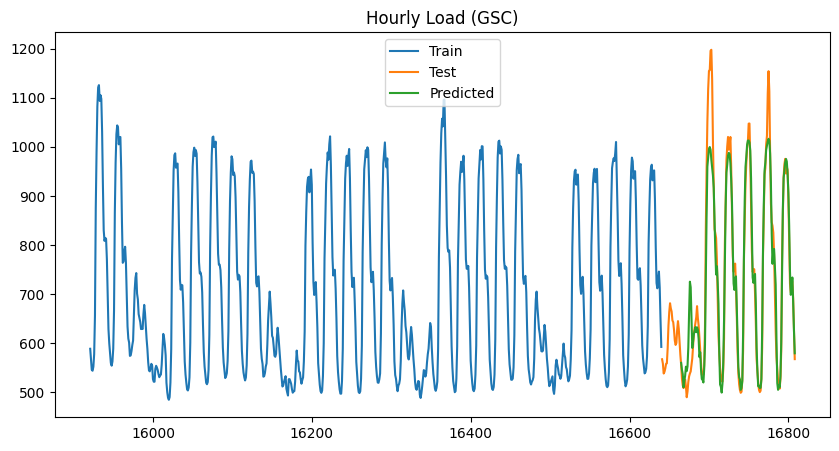

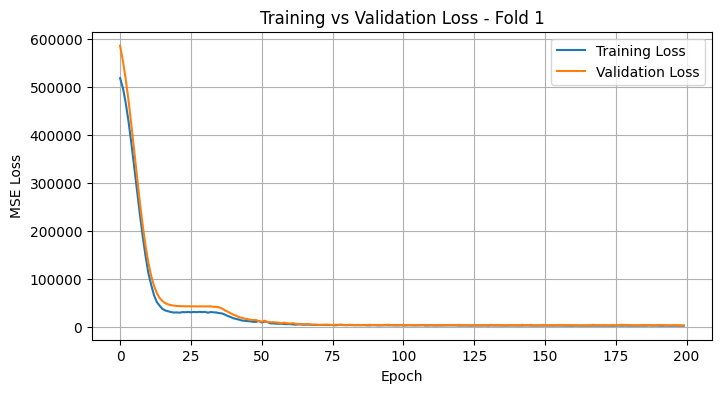

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 523531.9688 - val_loss: 587108.7500
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 498229.7500 - val_loss: 548895.3750
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 458827.0938 - val_loss: 502722.8438
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 412065.1562 - val_loss: 448976.8438
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 359480.0938 - val_loss: 389867.3750
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 303283.0000 - val_loss: 328742.7812
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 247841.2188 - val_loss: 269357.4375
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 197253.5938 - val_loss: 215034.2344
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 151082.7812 - val_loss: 167638.4219
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 113519.0312 - val_loss: 129834.6562
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

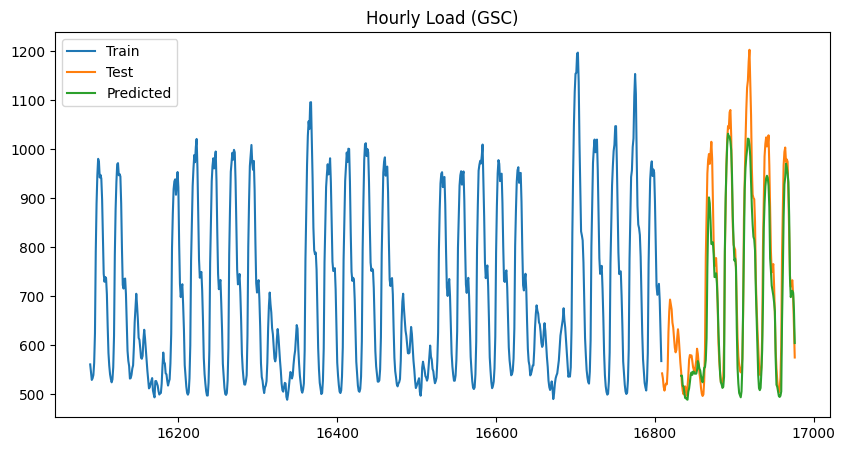

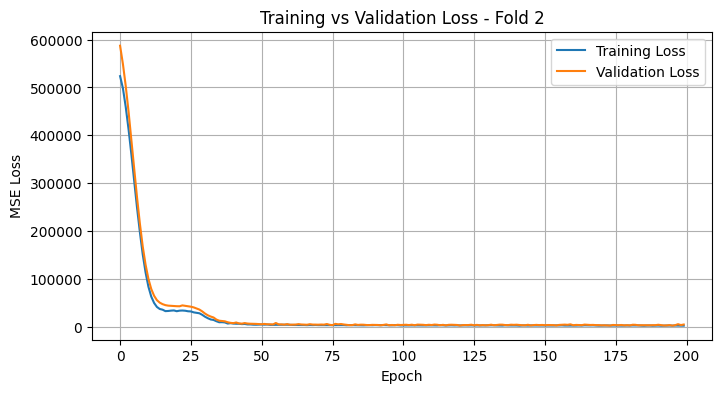

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 536497.6250 - val_loss: 548349.0625
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 506162.3438 - val_loss: 506245.1250
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 459597.3750 - val_loss: 453108.6250
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 403299.3438 - val_loss: 391885.9688
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 342354.9062 - val_loss: 327061.6875
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 279865.8438 - val_loss: 263191.5000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 218807.2656 - val_loss: 203635.7656
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 166809.8906 - val_loss: 152839.0000
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 121204.9766 - val_loss: 111859.6328
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87016.1172 - val_loss: 82472.4297
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

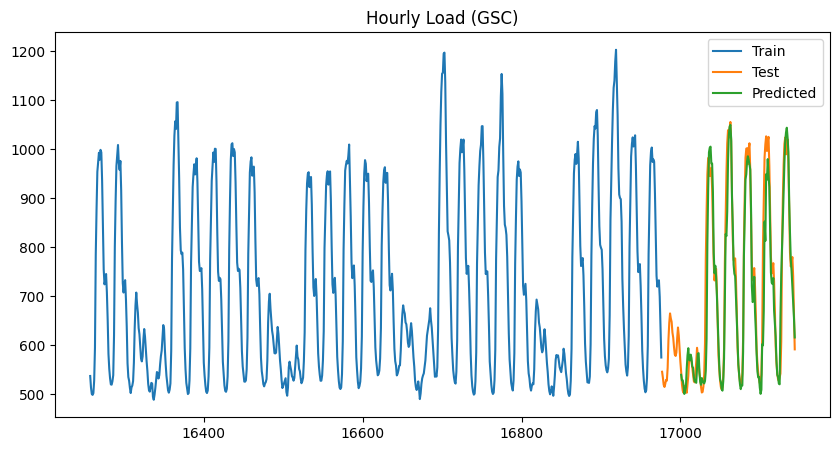

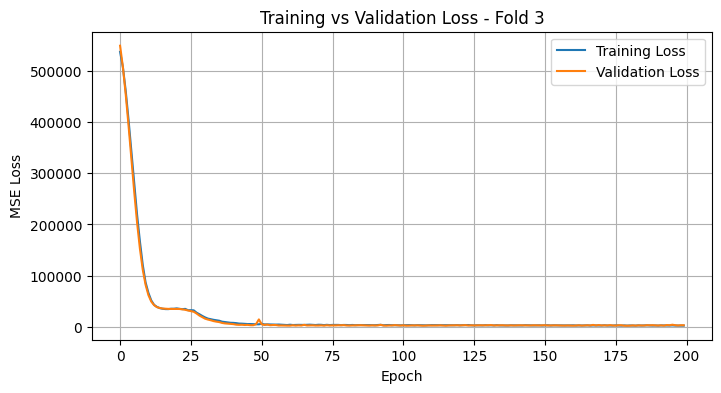

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 538008.0625 - val_loss: 680409.5000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 505264.6562 - val_loss: 633071.8750
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 460071.2188 - val_loss: 576806.5625
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 407583.0000 - val_loss: 512982.0625
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 349225.8750 - val_loss: 444253.2812
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 290286.7500 - val_loss: 374389.3438
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 232216.0156 - val_loss: 308264.2812
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179218.3906 - val_loss: 247682.4219
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 137035.4062 - val_loss: 196281.6875
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 100601.9062 - val_loss: 155713.3125
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

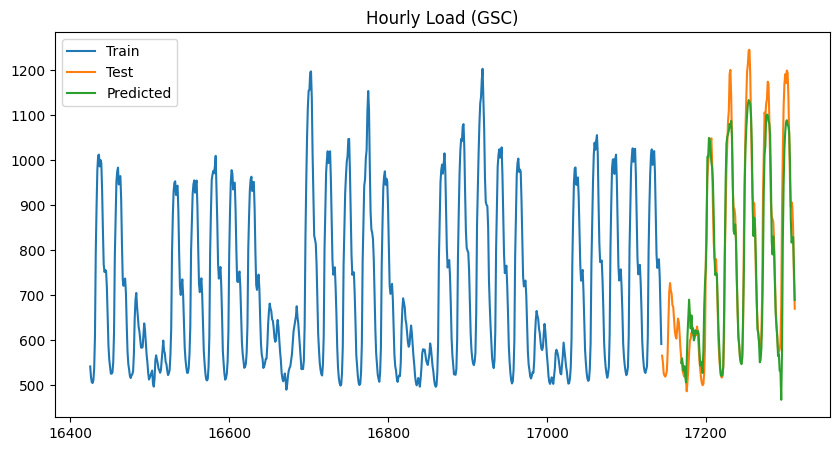

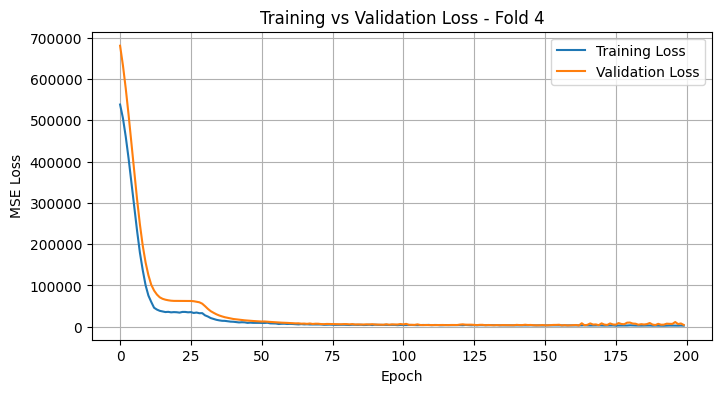

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 575069.6875 - val_loss: 652676.7500
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 549810.8750 - val_loss: 614546.8750
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 512937.4375 - val_loss: 570827.0625
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 468897.5312 - val_loss: 517922.3438
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 416428.3125 - val_loss: 457147.0625
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 357993.0625 - val_loss: 392710.1250
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 300986.5312 - val_loss: 328277.7812
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 244726.1875 - val_loss: 268106.1250
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 193358.0625 - val_loss: 212839.0938
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 150610.4844 - val_loss: 166724.6094
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

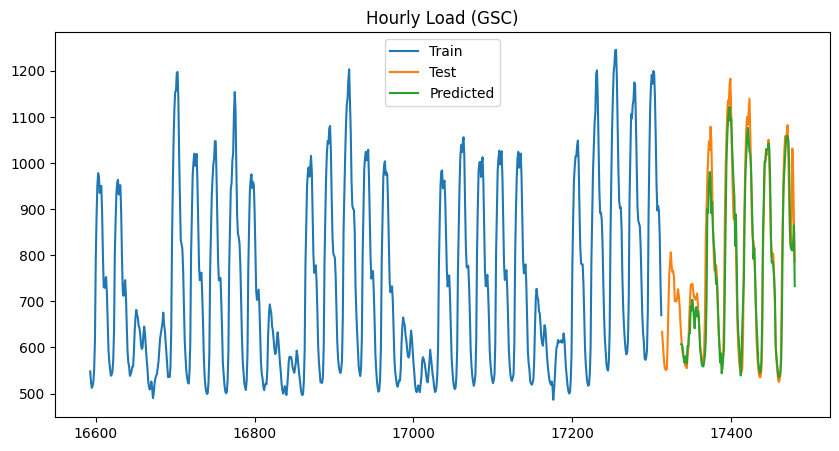

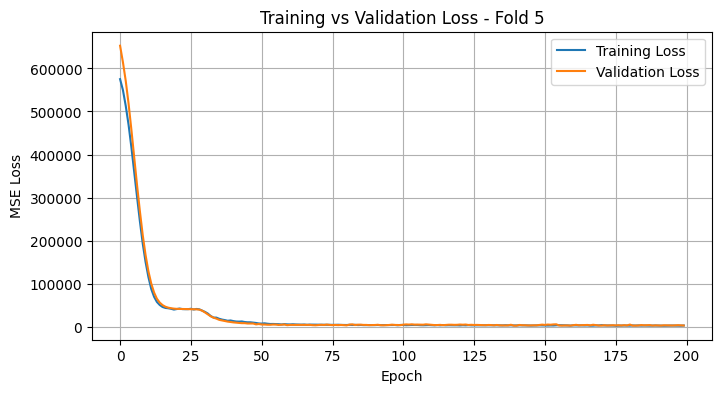

RES
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 914099.5625 - val_loss: 1080690.7500
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 880023.0000 - val_loss: 1033380.3125
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 831969.5000 - val_loss: 975355.6875
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 772472.6250 - val_loss: 904554.6250
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 701547.3750 - val_loss: 823000.0625
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 623100.3125 - val_loss: 734953.8750
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 540822.5000 - val_loss: 643417.7500
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 459642.9062 - val_loss: 552668.0000
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 378598.2812 - val_loss: 465927.1250
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 302645.5312 - val_loss: 386979.8750
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 

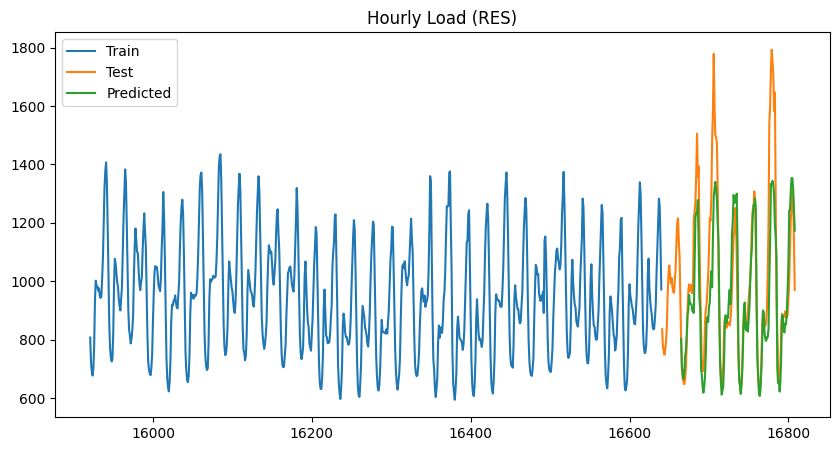

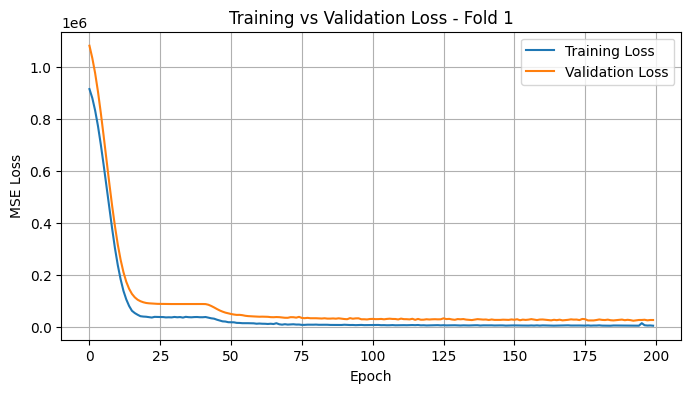

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 929059.0625 - val_loss: 1165230.1250
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 883322.9375 - val_loss: 1101400.8750
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 822754.1250 - val_loss: 1027337.4375
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 751223.8125 - val_loss: 941632.5625
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 670336.3125 - val_loss: 846672.4375
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 584159.0625 - val_loss: 747127.8750
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 497588.5625 - val_loss: 645522.2500
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 407644.6875 - val_loss: 548246.8125
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 328761.9688 - val_loss: 457074.6250
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 259809.9531 - val_loss: 376928.2188
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

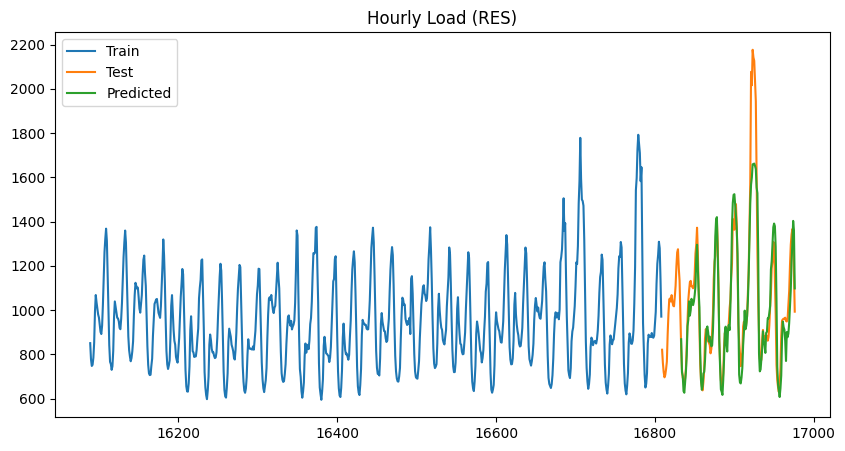

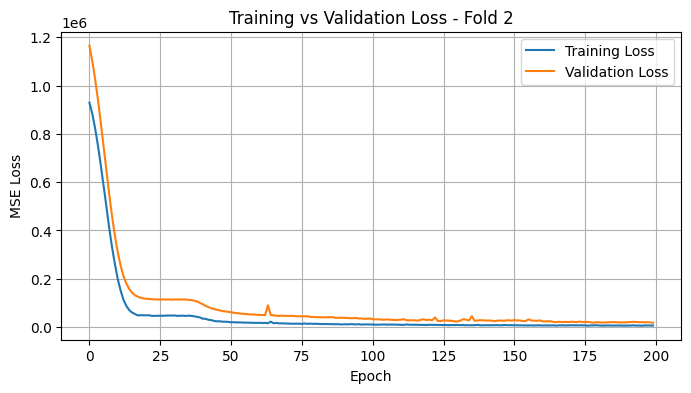

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 996552.3750 - val_loss: 925128.7500
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 976884.8750 - val_loss: 900101.7500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 945358.6250 - val_loss: 862152.6250
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 894328.8125 - val_loss: 791368.0000
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 808899.5000 - val_loss: 703531.2500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 714667.8750 - val_loss: 607983.0000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 614778.4375 - val_loss: 512124.8438
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 516354.8438 - val_loss: 414359.2188
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 419500.8750 - val_loss: 325033.6250
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 333656.6562 - val_loss: 245483.8906
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

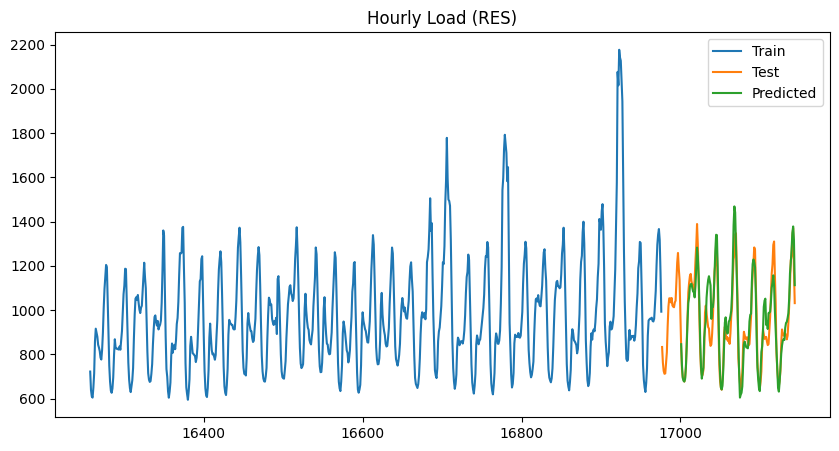

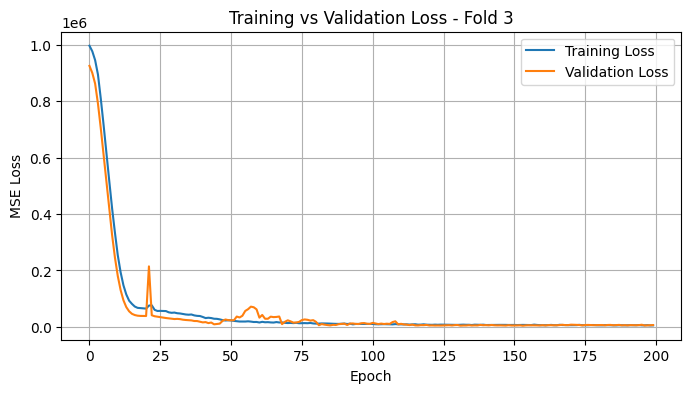

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1014545.3750 - val_loss: 1708628.1250
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 984252.3125 - val_loss: 1644890.5000
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 915671.9375 - val_loss: 1543613.5000
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 833121.1250 - val_loss: 1430138.8750
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 740527.8125 - val_loss: 1302123.5000
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 641567.0000 - val_loss: 1166637.7500
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 540845.0625 - val_loss: 1029144.8750
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 441685.2500 - val_loss: 896188.7500
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 353893.0938 - val_loss: 772109.1250
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 277220.9688 - val_loss: 662032.6250
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0

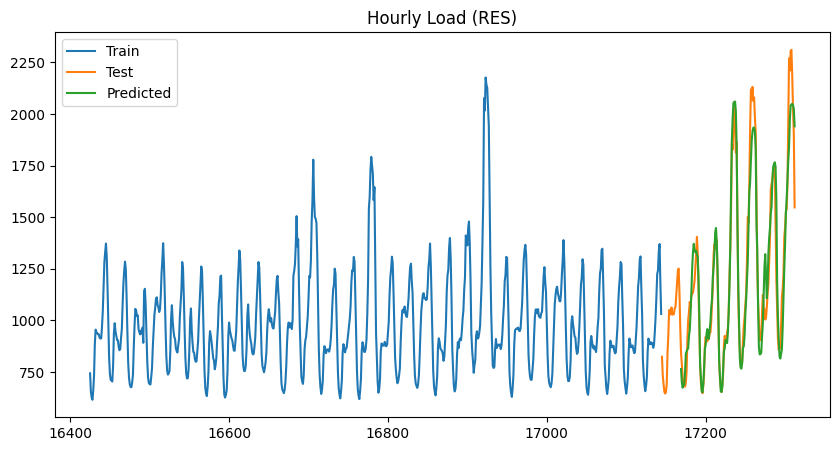

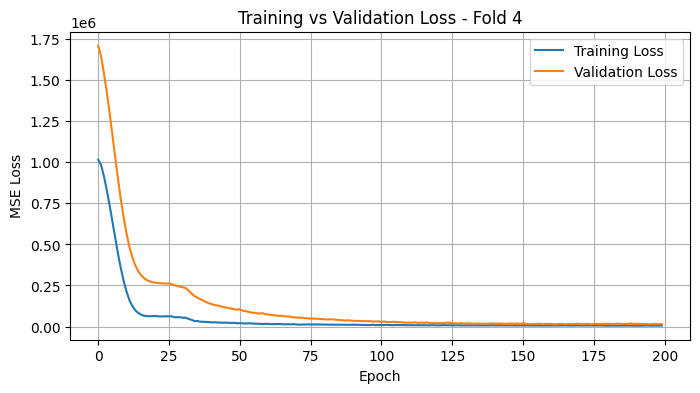

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1186499.0000 - val_loss: 1607644.2500
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1150463.3750 - val_loss: 1549019.8750
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1092098.6250 - val_loss: 1469404.3750
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1016300.2500 - val_loss: 1369086.8750
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 924987.1875 - val_loss: 1250557.2500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 822804.6250 - val_loss: 1121883.5000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 713674.1875 - val_loss: 987890.5625
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 603750.6250 - val_loss: 854066.6250
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 502386.8125 - val_loss: 726547.6250
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 407444.0000 - val_loss: 611598.8750
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━

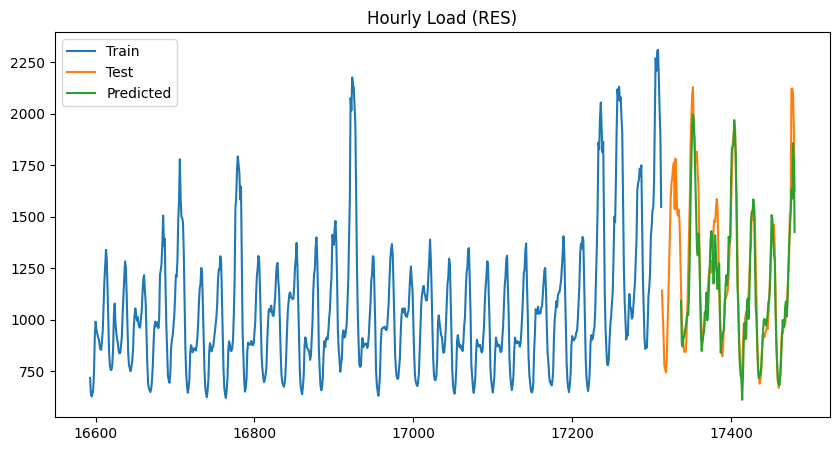

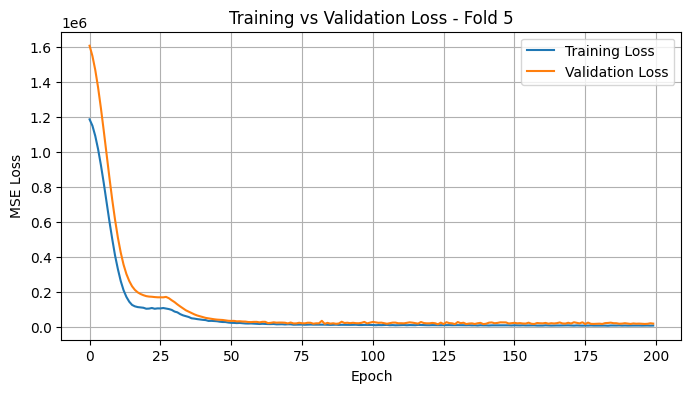

GPI
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1127.3713 - val_loss: 949.9688
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 370.5700 - val_loss: 64.9260
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.9158 - val_loss: 16.1758
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.3011 - val_loss: 16.7679
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.9190 - val_loss: 16.3434
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.2644 - val_loss: 14.8132
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.2593 - val_loss: 12.5209
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.8151 - val_loss: 9.6300
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4637 - val_loss: 9.4047
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1501 - val_loss: 7.5002
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.0065 - val_loss: 6.1587
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━

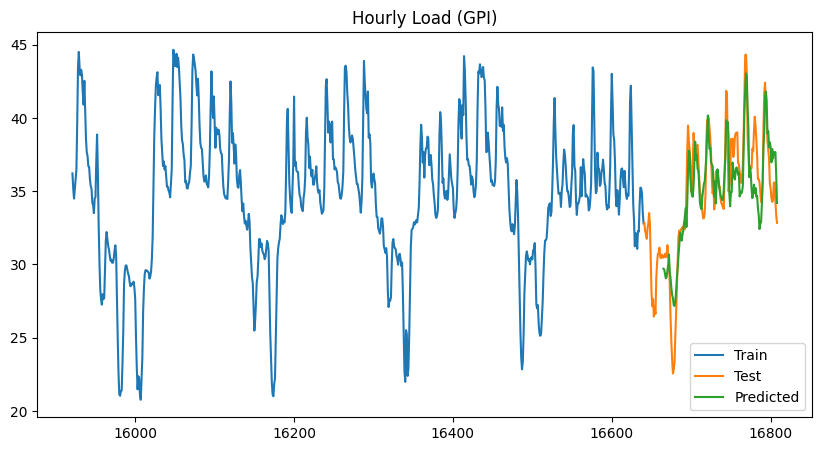

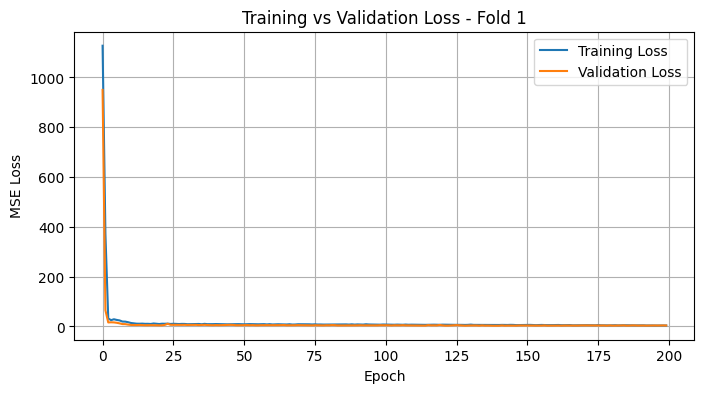

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1084.3959 - val_loss: 767.4598
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 188.0693 - val_loss: 13.1957
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.8644 - val_loss: 18.1863
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.4516 - val_loss: 18.3988
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9152 - val_loss: 17.8786
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.4573 - val_loss: 15.6793
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0425 - val_loss: 16.4410
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.3375 - val_loss: 11.5092
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.0477 - val_loss: 8.1517
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.8452 - val_loss: 6.1902
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.2147 - val_loss: 5.0927
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 

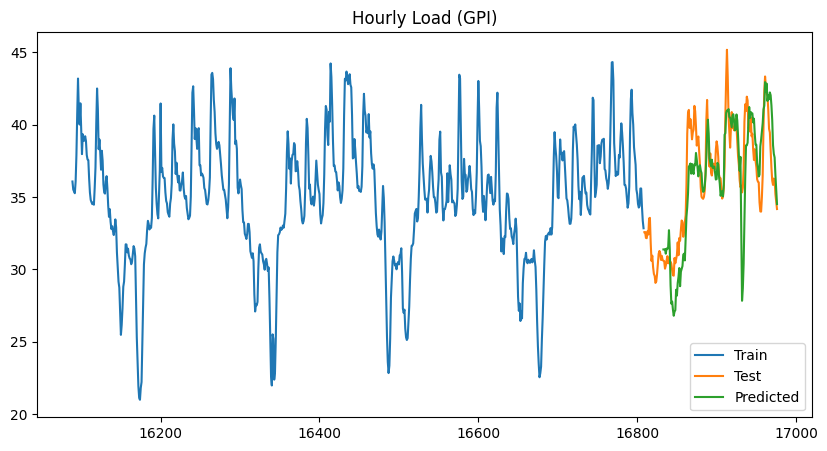

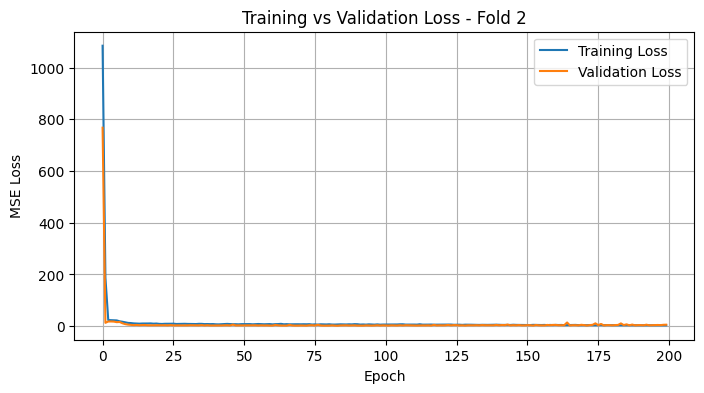

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1131.4363 - val_loss: 919.6014
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 275.1964 - val_loss: 38.2728
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.5822 - val_loss: 24.3292
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.7110 - val_loss: 22.6797
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.0346 - val_loss: 23.8560
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.2012 - val_loss: 22.1354
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7581 - val_loss: 20.8078
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3989 - val_loss: 19.0506
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1215 - val_loss: 14.8227
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.2819 - val_loss: 9.3861
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.1745 - val_loss: 12.1705
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━

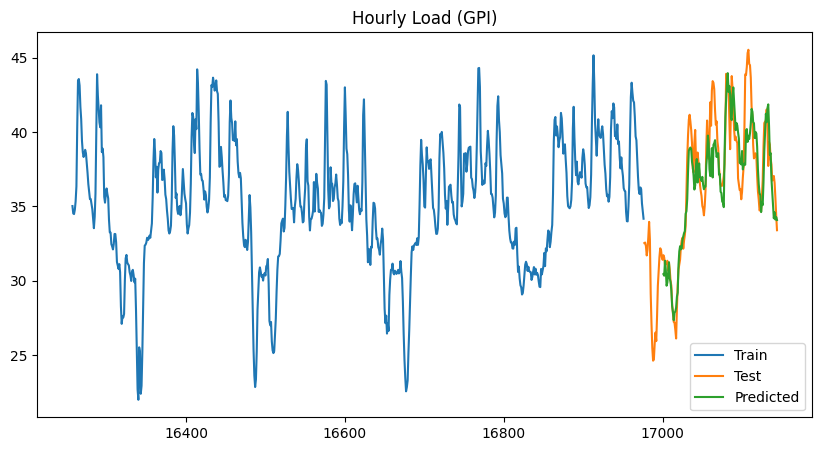

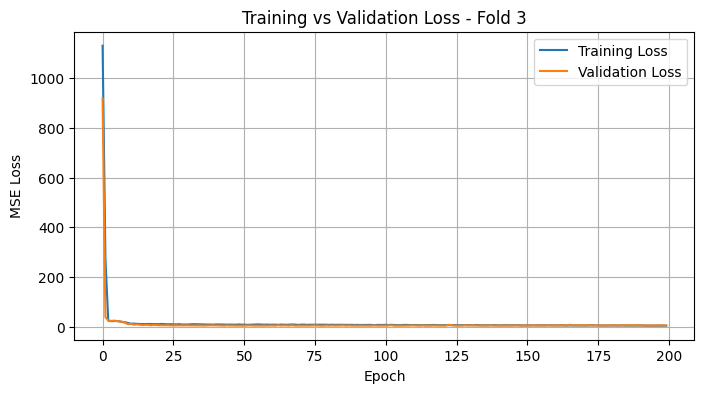

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1223.4705 - val_loss: 1164.2344
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 615.6495 - val_loss: 354.2909
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 122.1532 - val_loss: 53.2879
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.8234 - val_loss: 24.6722
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.0241 - val_loss: 25.2827
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0940 - val_loss: 24.2022
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.4695 - val_loss: 25.4044
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 23.8514 - val_loss: 25.5402
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.6560 - val_loss: 25.9692
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.8226 - val_loss: 24.2104
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.0880 - val_loss: 25.0826
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━

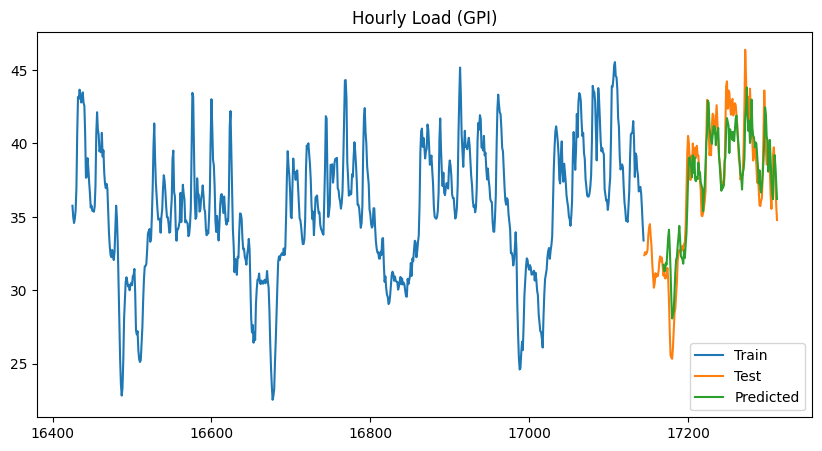

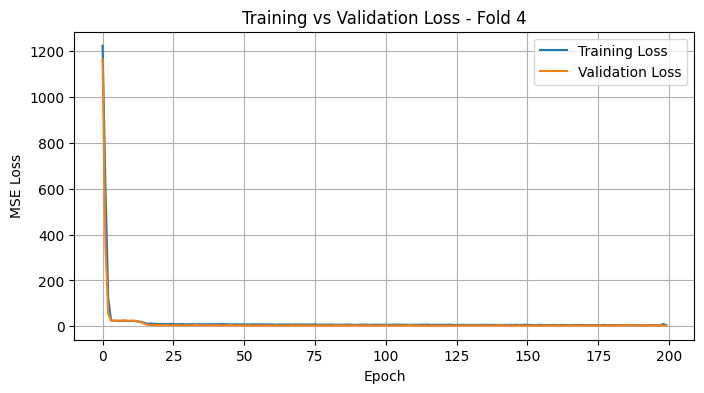

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1169.5728 - val_loss: 750.2941
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 312.6551 - val_loss: 32.2029
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.7948 - val_loss: 17.7294
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.4337 - val_loss: 17.5567
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.8942 - val_loss: 17.1744
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.4016 - val_loss: 16.5316
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.9828 - val_loss: 15.6285
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.6419 - val_loss: 13.7748
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.2124 - val_loss: 12.0245
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.9065 - val_loss: 9.3855
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9228 - val_loss: 8.8208
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━

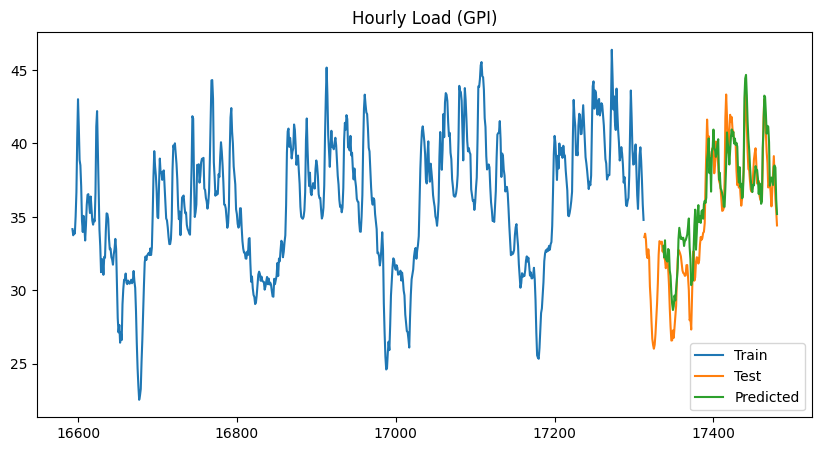

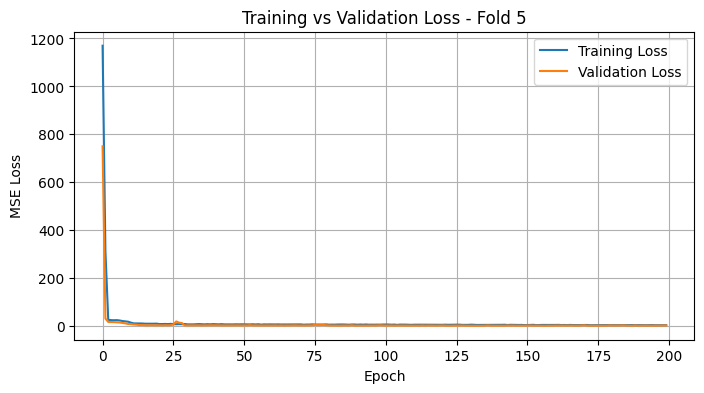

RSCP
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2562440.7500 - val_loss: 3611357.0000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2494243.0000 - val_loss: 3500137.2500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2398681.2500 - val_loss: 3376324.2500
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2284884.5000 - val_loss: 3224634.2500
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2145358.7500 - val_loss: 3044305.7500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1992191.6250 - val_loss: 2846448.5000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1825112.5000 - val_loss: 2634579.5000
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1647848.1250 - val_loss: 2410522.5000
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1467188.6250 - val_loss: 2182830.2500
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1288454.1250 - val_loss: 1954962.0000
Epoch 11/200
44/44 ━━━━━

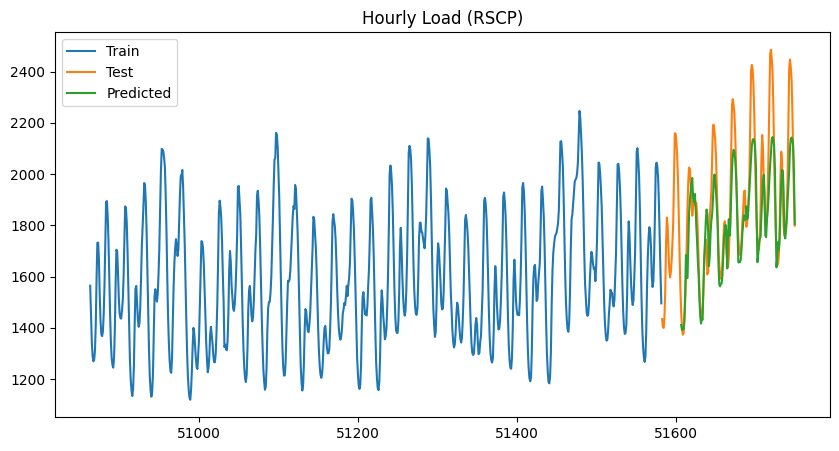

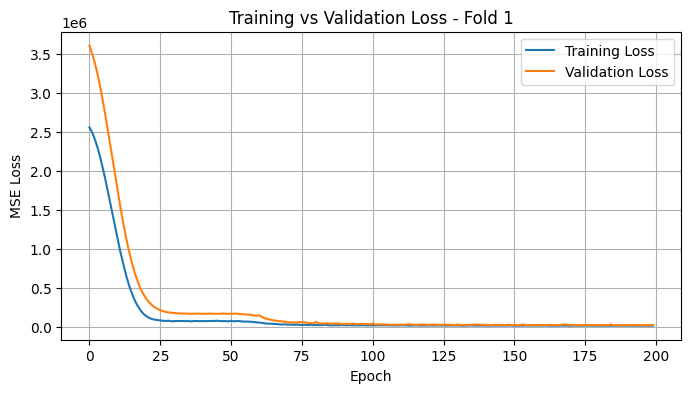

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2841166.5000 - val_loss: 3745896.5000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2785229.0000 - val_loss: 3655650.7500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2703223.5000 - val_loss: 3548947.5000
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2601242.5000 - val_loss: 3418741.0000
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2480493.5000 - val_loss: 3265970.2500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2339671.0000 - val_loss: 3093387.0000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2186006.5000 - val_loss: 2902824.5000
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2022339.6250 - val_loss: 2699328.5000
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1844466.7500 - val_loss: 2486156.7500
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1666127.2500 - val_loss: 2268296.5000
Epoch 11/200
44/44 ━━━━━━━━━━

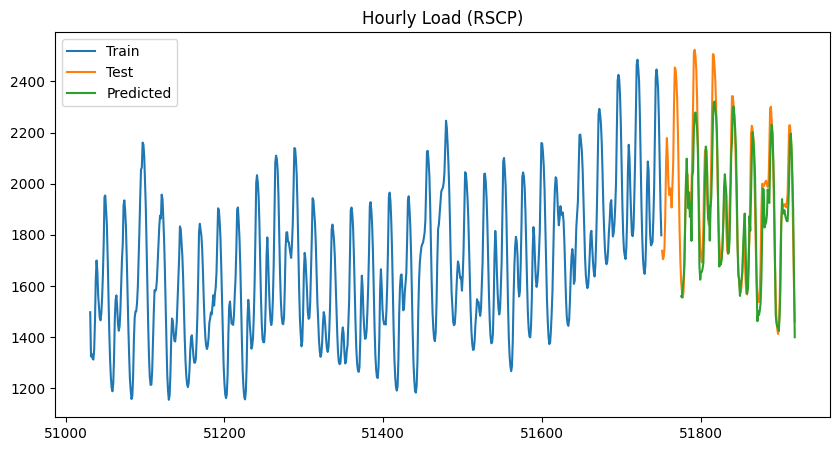

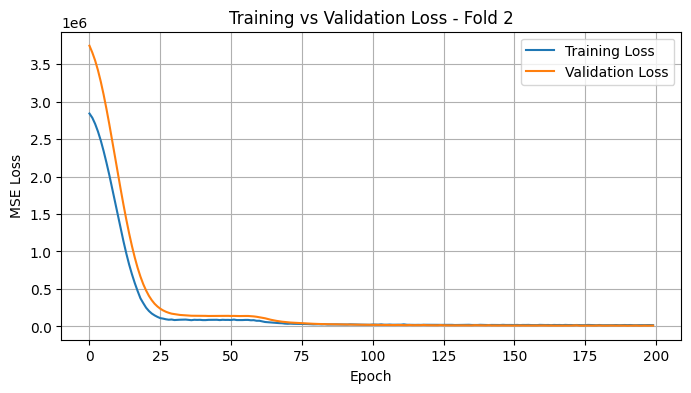

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3176427.5000 - val_loss: 3951428.5000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3087984.2500 - val_loss: 3813585.2500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2955740.5000 - val_loss: 3646643.0000
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2790856.0000 - val_loss: 3440066.7500
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2593640.0000 - val_loss: 3198701.2500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2373490.0000 - val_loss: 2932030.0000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2127812.5000 - val_loss: 2645105.5000
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1876391.1250 - val_loss: 2348823.7500
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1625012.3750 - val_loss: 2054485.5000
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1380995.5000 - val_loss: 1768099.8750
Epoch 11/200
44/44 ━━━━━━━━━━

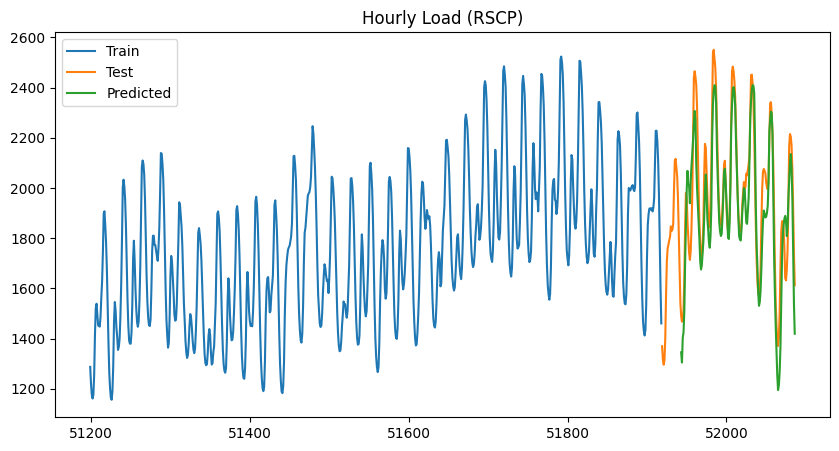

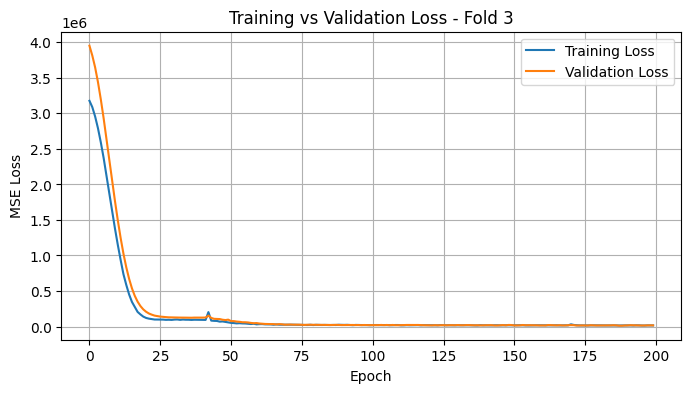

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3487722.7500 - val_loss: 4852163.5000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3418369.0000 - val_loss: 4764788.5000
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3315675.5000 - val_loss: 4650264.5000
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3191000.2500 - val_loss: 4508102.0000
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3047007.0000 - val_loss: 4344333.0000
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2880543.5000 - val_loss: 4156588.0000
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2689019.0000 - val_loss: 3937722.7500
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2475531.2500 - val_loss: 3702400.5000
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2257364.2500 - val_loss: 3452344.2500
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2019999.8750 - val_loss: 3184337.7500
Epoch 11/200
44/44 ━━━━━━━━━━

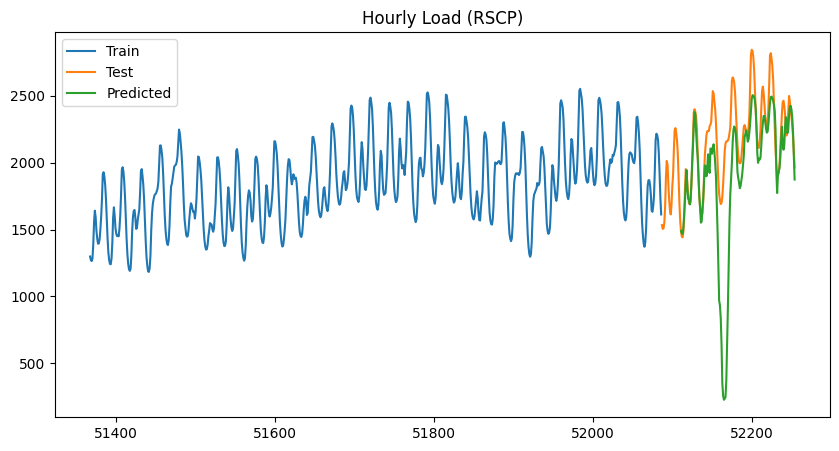

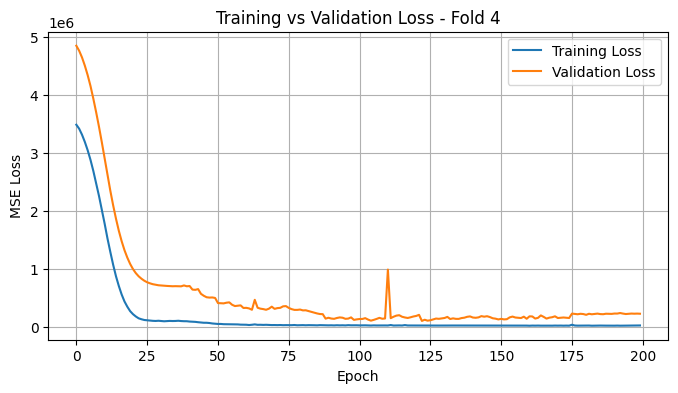

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3941626.0000 - val_loss: 3657222.0000
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3878504.7500 - val_loss: 3549255.2500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3740071.7500 - val_loss: 3399960.0000
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3571506.0000 - val_loss: 3223207.0000
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3375971.7500 - val_loss: 3021673.7500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3158302.5000 - val_loss: 2799341.7500
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2910991.7500 - val_loss: 2558742.2500
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2650816.0000 - val_loss: 2307871.0000
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2390584.2500 - val_loss: 2051211.5000
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2128102.0000 - val_loss: 1799728.5000
Epoch 11/200
44/44 ━━━━━━━━━━

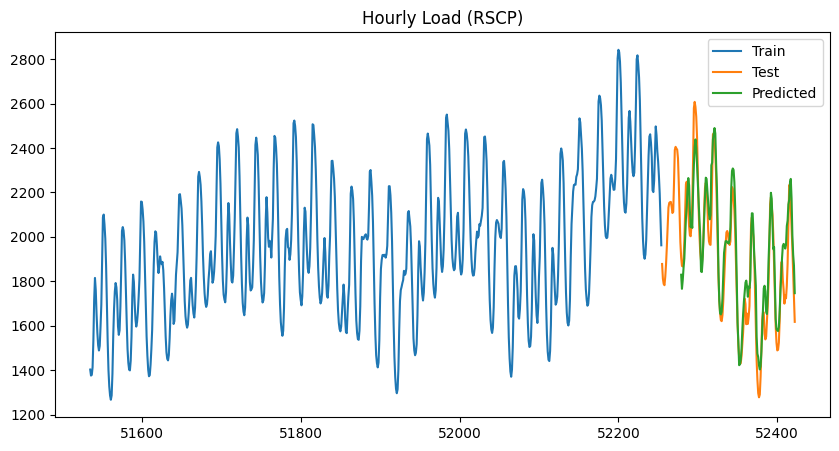

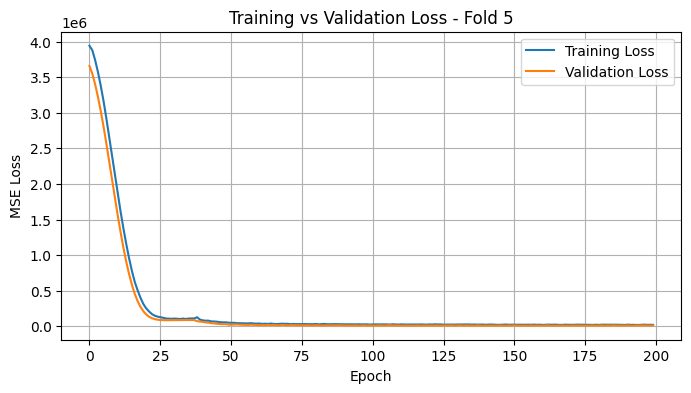

GSTC
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1472.2997 - val_loss: 1380.1228
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 540.9244 - val_loss: 220.5500
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78.0612 - val_loss: 120.5311
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.9666 - val_loss: 123.7578
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.7366 - val_loss: 124.4652
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.8619 - val_loss: 118.8765
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.3426 - val_loss: 115.6373
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61.5609 - val_loss: 103.0888
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.8755 - val_loss: 85.0741
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.1898 - val_loss: 62.0925
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.2432 - val_loss: 45.9275
Epoch 12/200
44/44 ━━━━━

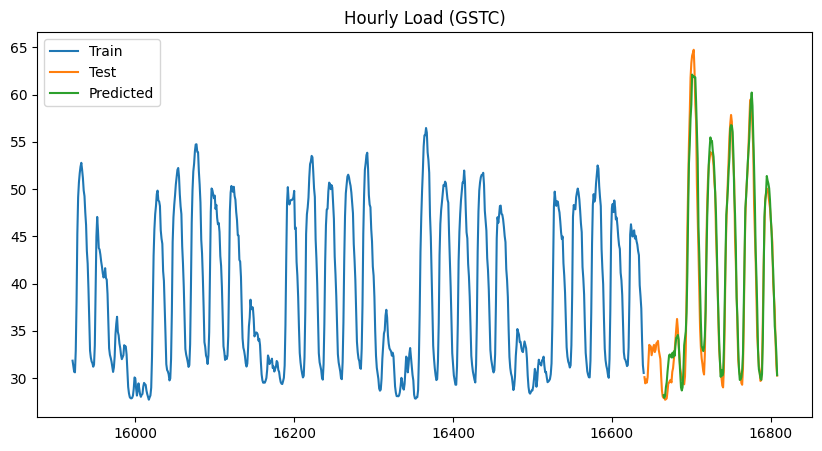

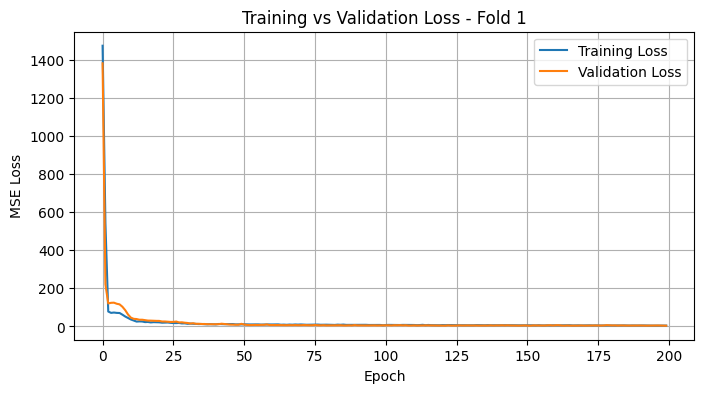

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1545.4086 - val_loss: 1530.8960
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 759.3019 - val_loss: 374.3793
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 132.3516 - val_loss: 117.9920
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 83.0590 - val_loss: 116.7473
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80.7441 - val_loss: 115.8900
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79.8605 - val_loss: 109.4924
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75.4480 - val_loss: 101.3231
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 64.6104 - val_loss: 87.9358
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.4771 - val_loss: 68.5758
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.9247 - val_loss: 53.7056
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.7451 - val_loss: 40.9096
Epoch 12/200
44/44 ━━━━━━━━━━

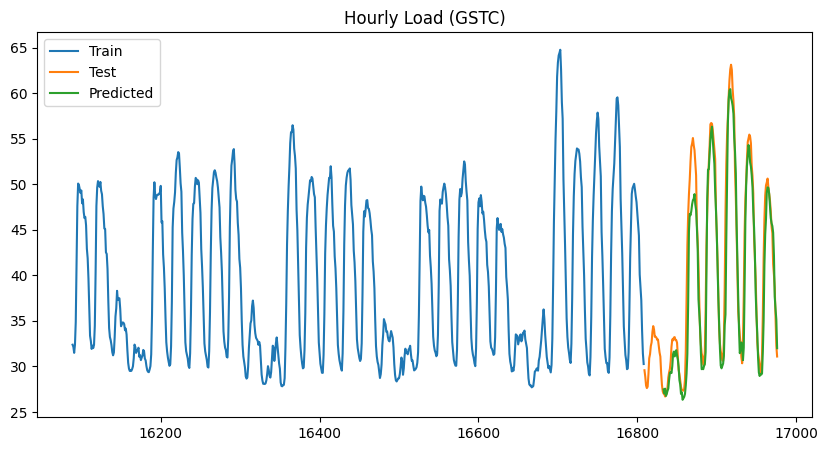

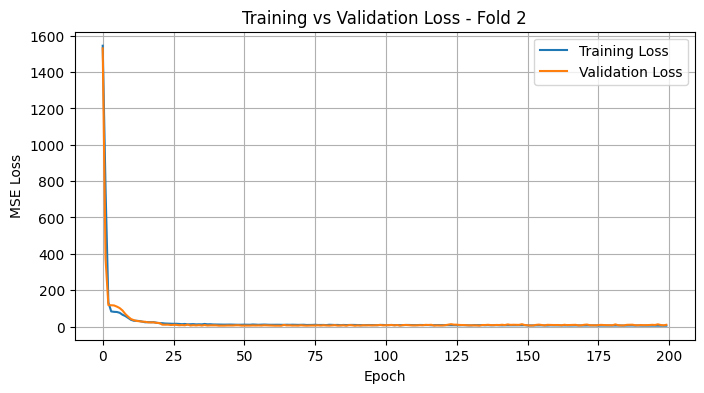

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1598.6083 - val_loss: 1526.1014
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 956.3625 - val_loss: 577.1935
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 293.6037 - val_loss: 159.5653
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107.8682 - val_loss: 95.1523
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.8184 - val_loss: 93.7456
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 96.3802 - val_loss: 93.7499
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.3363 - val_loss: 93.7636
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.9282 - val_loss: 92.6853
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.0670 - val_loss: 87.7309
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 83.3123 - val_loss: 74.4380
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.8441 - val_loss: 58.5329
Epoch 12/200
44/44 ━━━━━━━━━━━━━

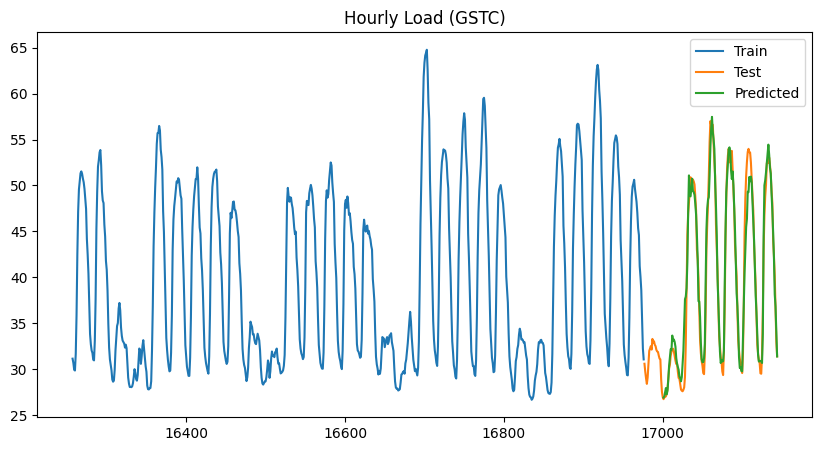

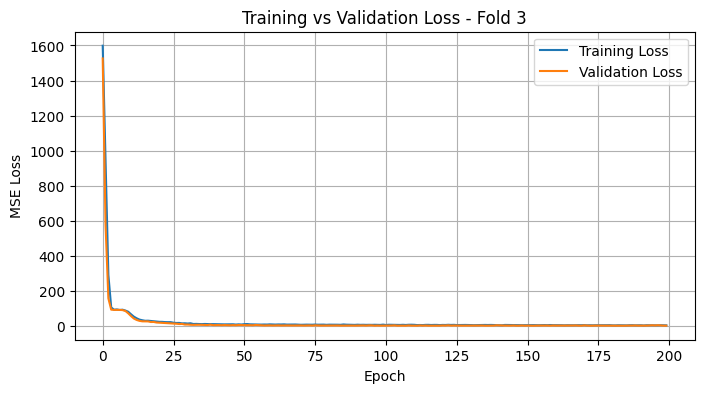

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1459.6534 - val_loss: 1259.0381
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 424.9875 - val_loss: 251.8634
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.0777 - val_loss: 158.3384
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 97.4104 - val_loss: 166.6163
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.5877 - val_loss: 154.7493
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84.6775 - val_loss: 141.5361
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 73.2985 - val_loss: 114.9909
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.0132 - val_loss: 82.8633
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.7735 - val_loss: 63.3740
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.5821 - val_loss: 52.6707
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.5354 - val_loss: 46.7617
Epoch 12/200
44/44 ━━━━━━━━━━

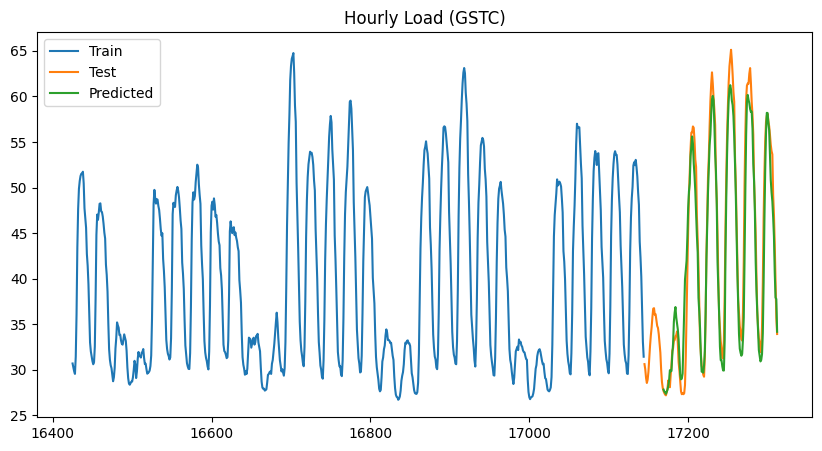

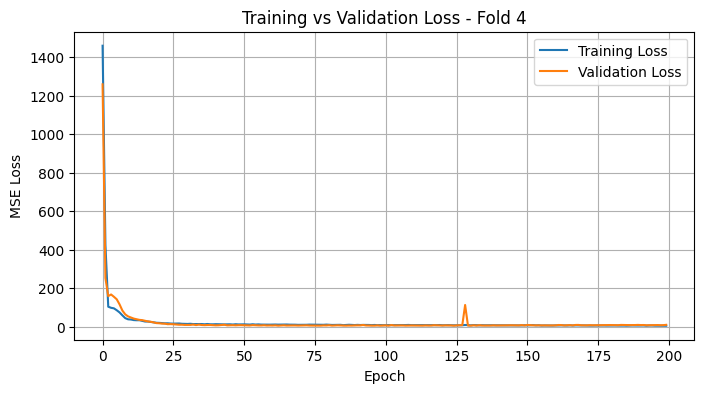

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1588.0525 - val_loss: 1174.9465
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 540.8845 - val_loss: 162.5793
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 120.8676 - val_loss: 94.5725
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 121.1215 - val_loss: 98.2039
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 116.4945 - val_loss: 95.6208
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 114.3096 - val_loss: 88.9500
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.4982 - val_loss: 68.0129
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.0306 - val_loss: 45.1438
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.6062 - val_loss: 33.7054
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.4087 - val_loss: 28.7466
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.9477 - val_loss: 25.0160
Epoch 12/200
44/44 ━━━━━━━━━━━━

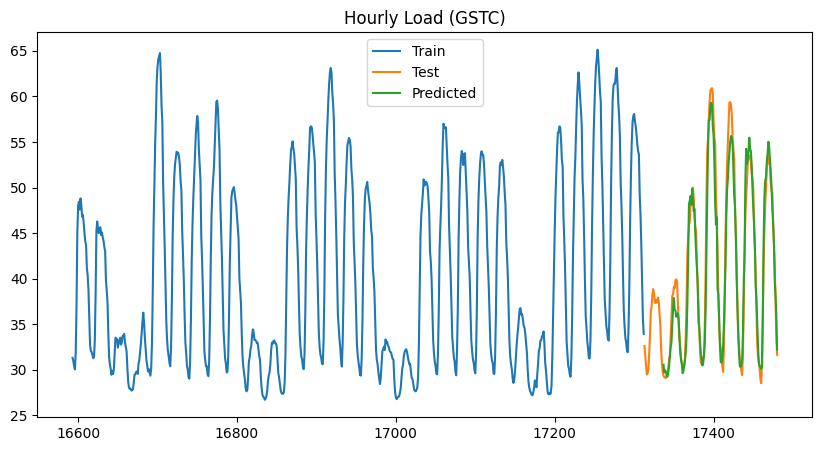

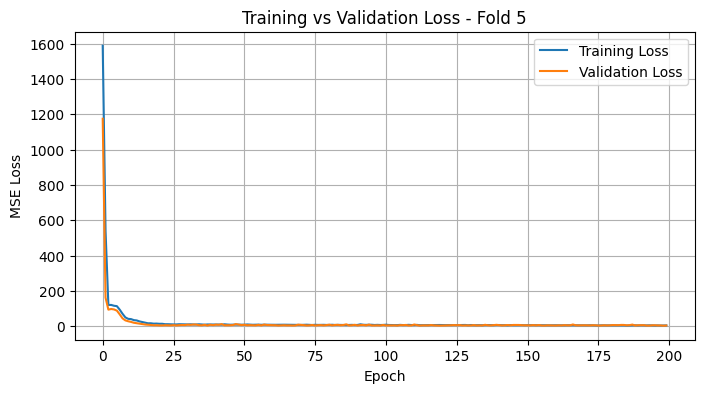

GTC
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3339.5032 - val_loss: 3197.4331
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1439.0601 - val_loss: 830.0624
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 215.3760 - val_loss: 124.6425
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.7167 - val_loss: 72.0804
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.8716 - val_loss: 72.6994
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.8730 - val_loss: 75.9998
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.2370 - val_loss: 71.8413
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.4710 - val_loss: 76.3089
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.9263 - val_loss: 68.3340
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.4504 - val_loss: 67.1463
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.5937 - val_loss: 55.9077
Epoch 12/200
44/44 ━━━━━━━━━

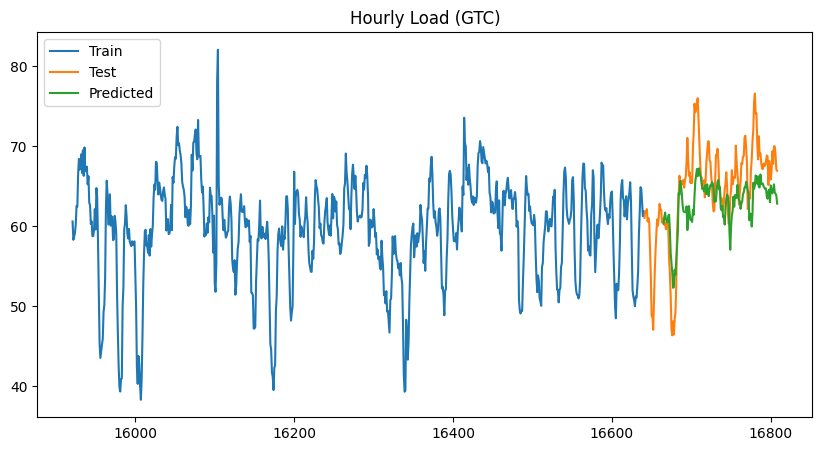

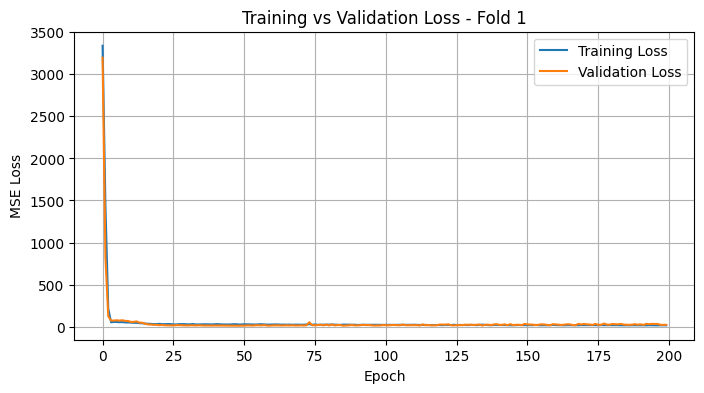

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3389.2932 - val_loss: 3235.7288
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1497.8625 - val_loss: 1001.1964
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 253.5990 - val_loss: 179.3537
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.8496 - val_loss: 101.5421
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.6937 - val_loss: 104.9819
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.0291 - val_loss: 100.6416
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.0005 - val_loss: 92.8895
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.1278 - val_loss: 94.3972
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.8012 - val_loss: 93.1013
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.1938 - val_loss: 121.9205
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.2473 - val_loss: 396.1111
Epoch 12/200
44/44 ━━━━━━━

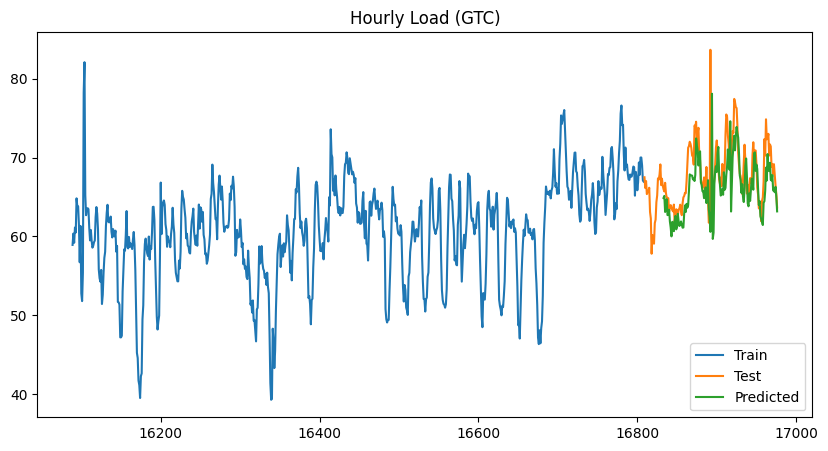

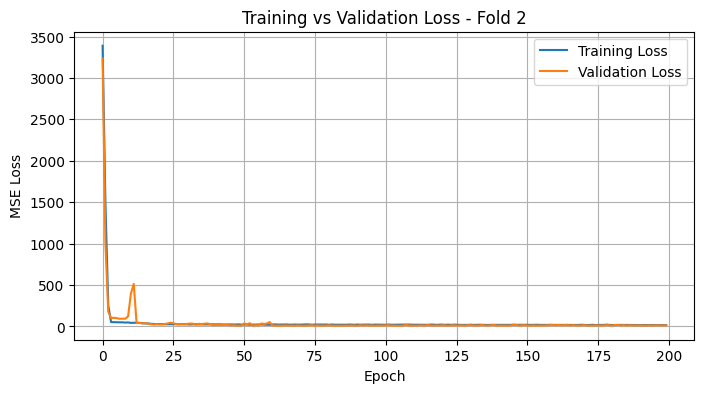

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3643.6477 - val_loss: 2946.1033
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1647.8544 - val_loss: 971.0098
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 360.8519 - val_loss: 150.3474
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 64.9928 - val_loss: 44.0591
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.0481 - val_loss: 45.3928
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.0761 - val_loss: 43.3385
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.9908 - val_loss: 44.9672
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.1904 - val_loss: 41.3073
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.1516 - val_loss: 45.5175
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.3635 - val_loss: 39.7519
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.0408 - val_loss: 41.8811
Epoch 12/200
44/44 ━━━━━━━━━━━━━

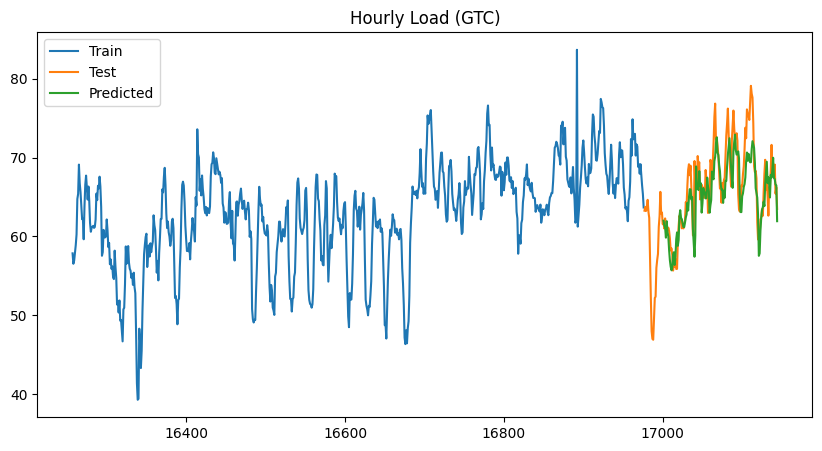

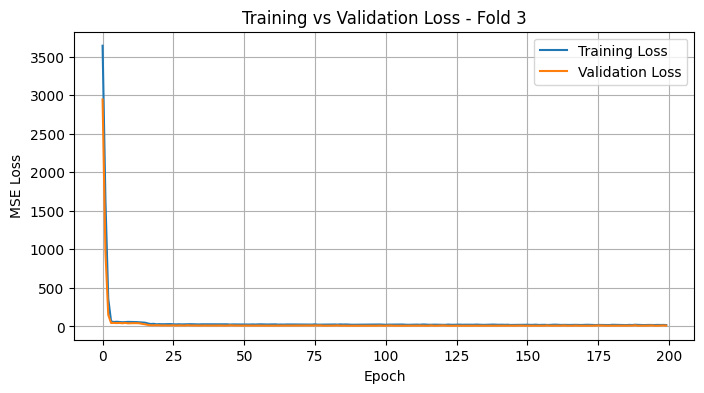

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3785.8440 - val_loss: 2802.7737
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1627.6241 - val_loss: 639.2249
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 243.1186 - val_loss: 38.0725
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.8847 - val_loss: 29.9906
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.2558 - val_loss: 29.8387
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53.8409 - val_loss: 29.7591
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.5105 - val_loss: 29.8709
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.0148 - val_loss: 29.1756
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.4702 - val_loss: 28.4424
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.8921 - val_loss: 27.0982
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.4561 - val_loss: 26.2267
Epoch 12/200
44/44 ━━━━━━━━━━━━━━

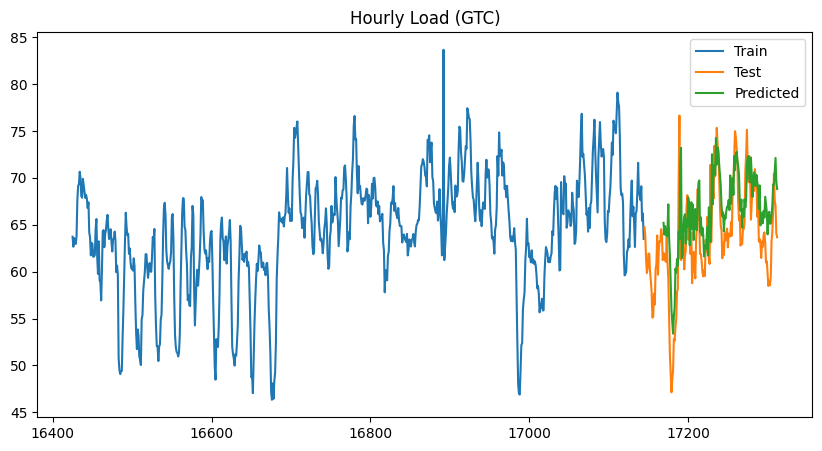

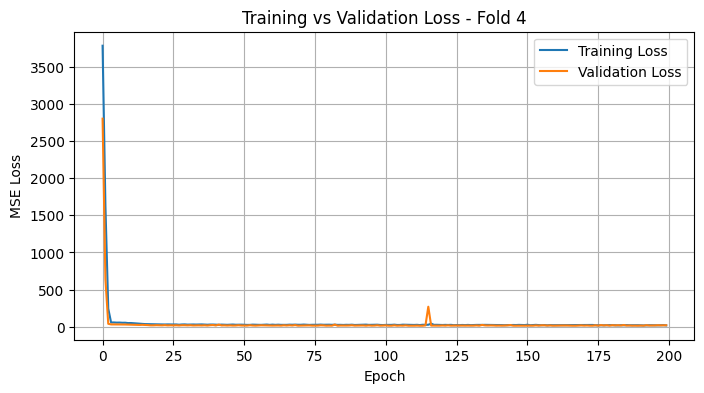

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4065.1655 - val_loss: 3131.9043
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2541.0459 - val_loss: 1449.8032
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 811.1407 - val_loss: 239.8484
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 137.3972 - val_loss: 75.3456
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 52.0431 - val_loss: 84.8288
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.5631 - val_loss: 87.5869
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.7237 - val_loss: 90.3397
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.4172 - val_loss: 91.9359
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48.5175 - val_loss: 95.3482
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51.0483 - val_loss: 115.3088
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.2508 - val_loss: 134.5608
Epoch 12/200
44/44 ━━━━━━━━━

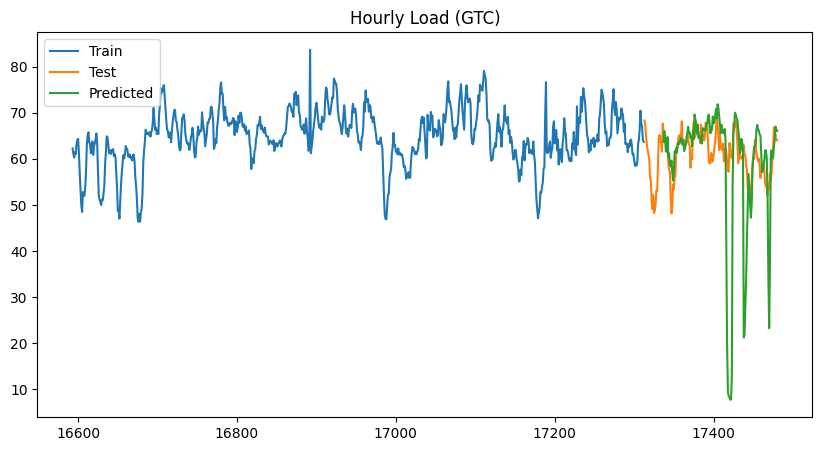

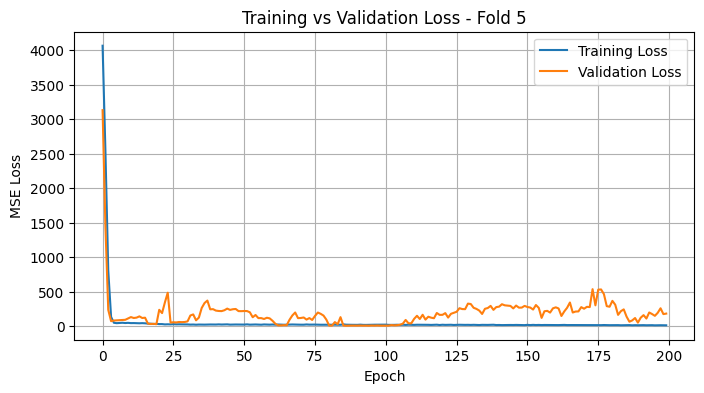

GSTI
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.5528 - val_loss: 1.7597
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0022 - val_loss: 1.0952
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0807 - val_loss: 0.6303
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9751 - val_loss: 0.6526
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9021 - val_loss: 0.6577
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7948 - val_loss: 0.5991
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7499 - val_loss: 0.6196
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6887 - val_loss: 0.6358
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6297 - val_loss: 0.5168
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6186 - val_loss: 0.6888
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5898 - val_loss: 0.5851
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

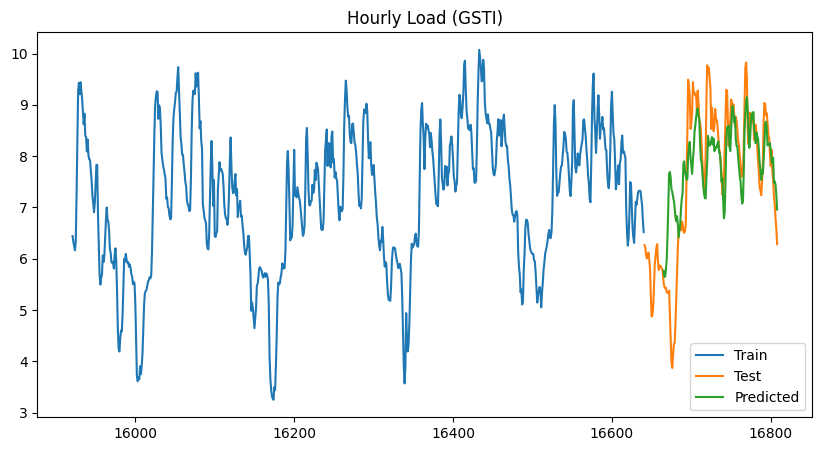

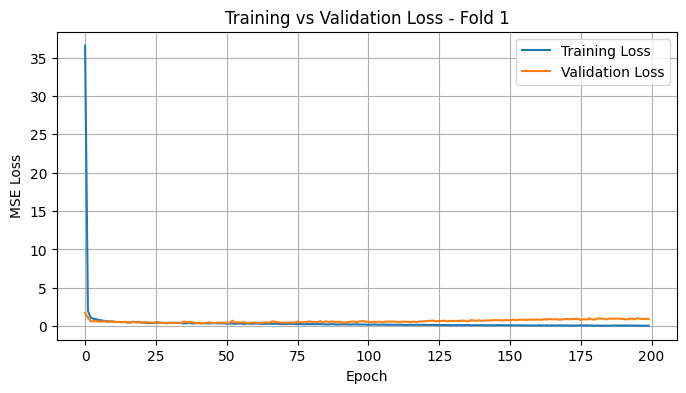

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 37.2396 - val_loss: 2.6028
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0070 - val_loss: 1.2781
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0880 - val_loss: 1.1723
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9175 - val_loss: 0.7178
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8819 - val_loss: 0.6918
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7657 - val_loss: 0.6862
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7387 - val_loss: 0.5571
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6928 - val_loss: 0.5403
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6694 - val_loss: 0.5149
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6748 - val_loss: 0.6726
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6048 - val_loss: 0.4724
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

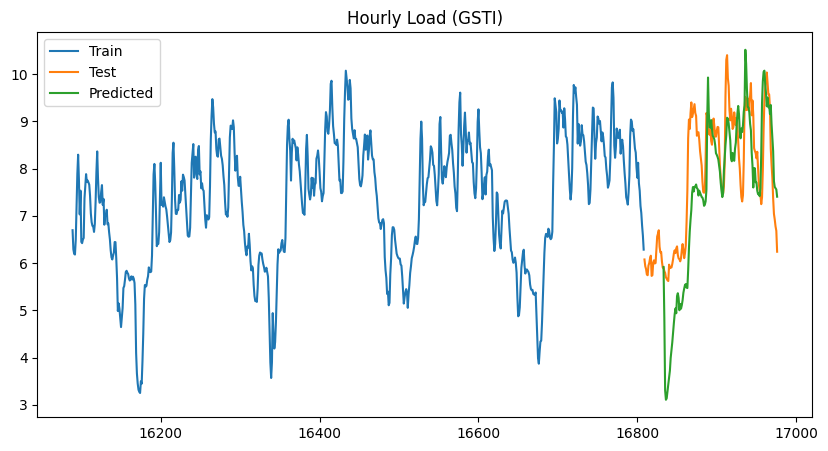

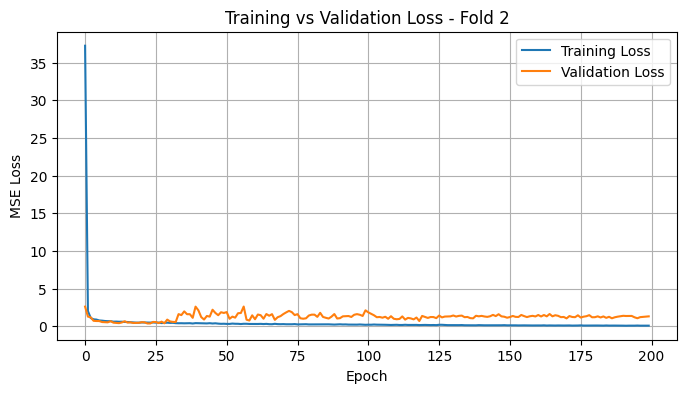

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 47.2213 - val_loss: 16.2245
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7583 - val_loss: 1.9510
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2091 - val_loss: 1.1388
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9606 - val_loss: 0.9744
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7855 - val_loss: 0.9669
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7687 - val_loss: 0.9113
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7179 - val_loss: 0.8821
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6769 - val_loss: 0.8708
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6690 - val_loss: 0.7136
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5565 - val_loss: 0.6457
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5170 - val_loss: 0.7317
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

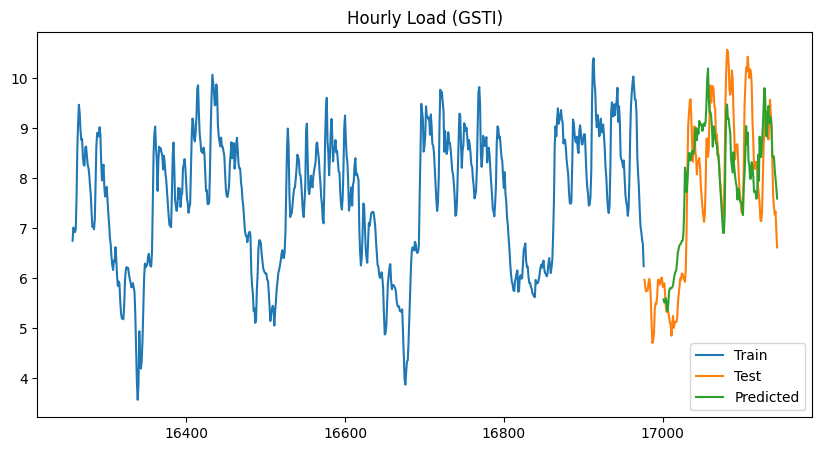

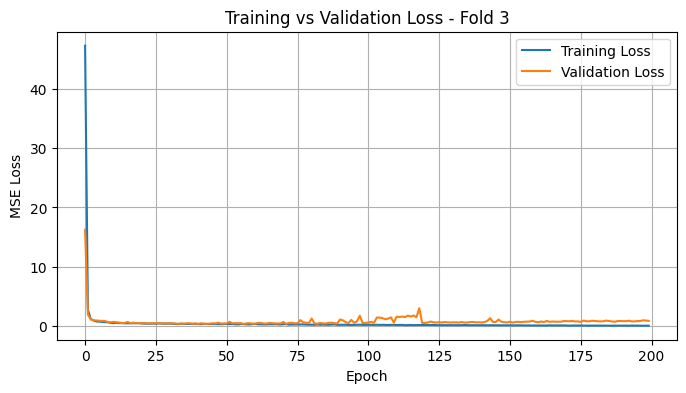

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 33.6293 - val_loss: 6.5705
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6984 - val_loss: 1.5761
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4155 - val_loss: 1.0173
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1928 - val_loss: 0.6856
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9518 - val_loss: 0.5929
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8514 - val_loss: 0.6258
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8473 - val_loss: 0.5637
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7450 - val_loss: 0.5047
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6964 - val_loss: 0.4163
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7243 - val_loss: 0.7120
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6810 - val_loss: 0.5502
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

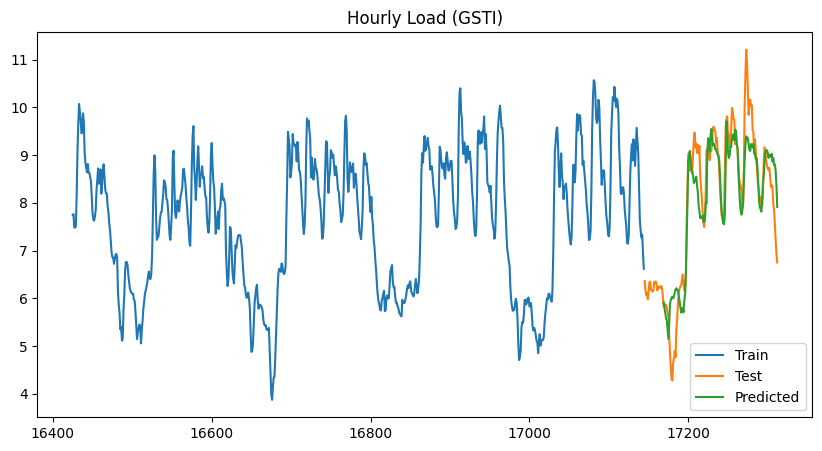

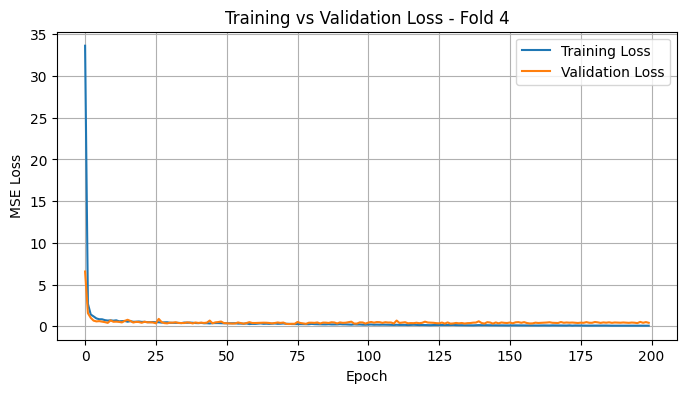

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36.1147 - val_loss: 9.4349
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8974 - val_loss: 2.6711
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7050 - val_loss: 2.2428
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4866 - val_loss: 1.3695
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2930 - val_loss: 1.3895
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1551 - val_loss: 0.8324
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0280 - val_loss: 0.5243
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9163 - val_loss: 0.5871
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7991 - val_loss: 0.5957
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7545 - val_loss: 0.4791
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7094 - val_loss: 0.5311
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

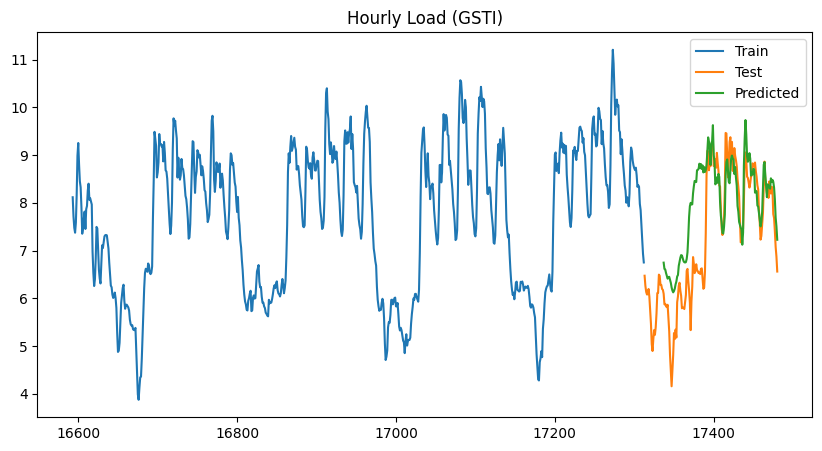

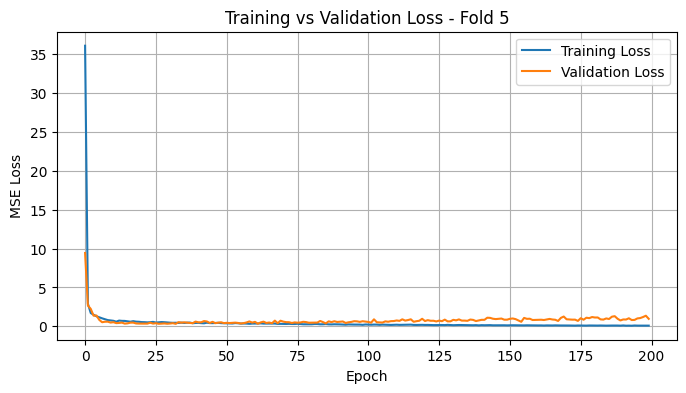

GTI
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8755.6172 - val_loss: 6907.6250
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5730.0220 - val_loss: 3313.0688
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2799.6829 - val_loss: 1297.0945
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1143.2794 - val_loss: 498.7245
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 556.6401 - val_loss: 391.1278
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 447.1198 - val_loss: 414.0896
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 452.5064 - val_loss: 424.7205
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 437.6048 - val_loss: 423.3272
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 444.5025 - val_loss: 416.7389
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 436.1392 - val_loss: 401.4901
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 420.9557 - val_loss: 395.5355
Epoch 12

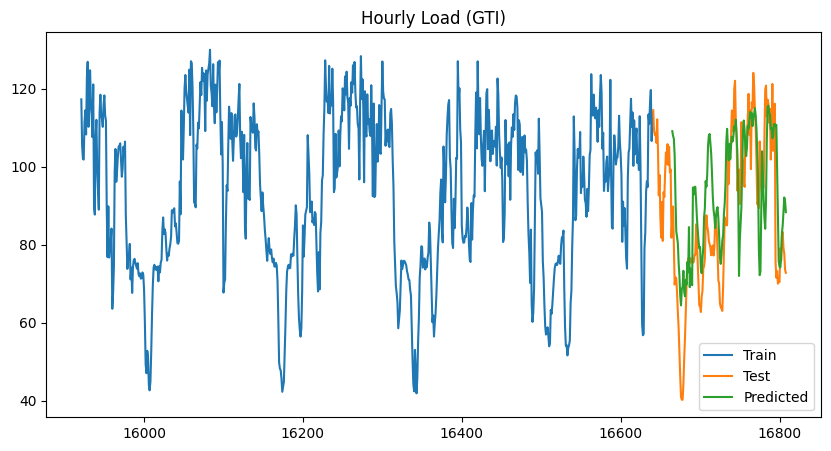

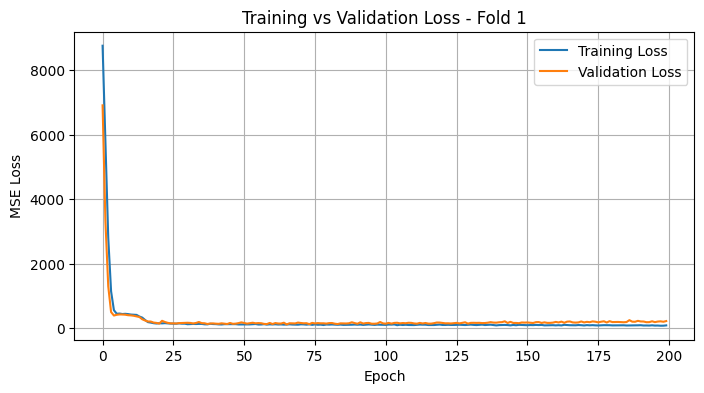

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8561.7861 - val_loss: 7982.4746
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5511.1606 - val_loss: 3206.7827
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2001.8186 - val_loss: 849.5732
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 602.4672 - val_loss: 344.0319
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 424.3329 - val_loss: 330.0253
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 436.4090 - val_loss: 330.2696
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 431.9975 - val_loss: 329.1003
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 418.3783 - val_loss: 327.1117
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 426.1785 - val_loss: 324.4699
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 403.0453 - val_loss: 318.8923
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 400.3664 - val_loss: 304.0163
Epoch 12/200
4

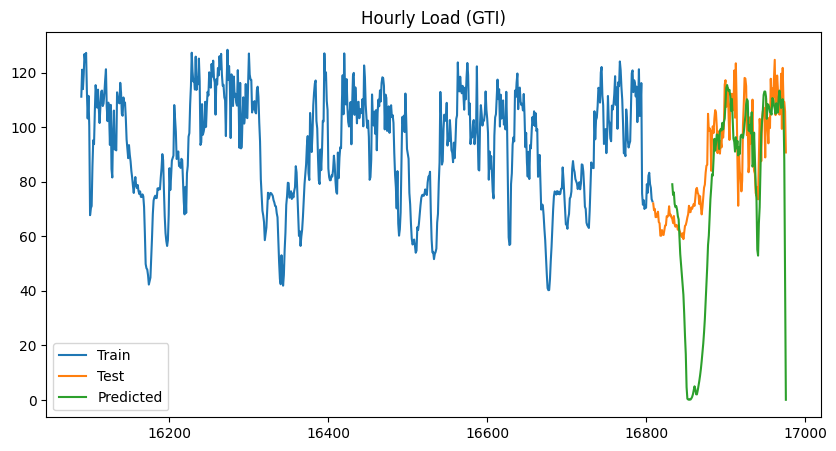

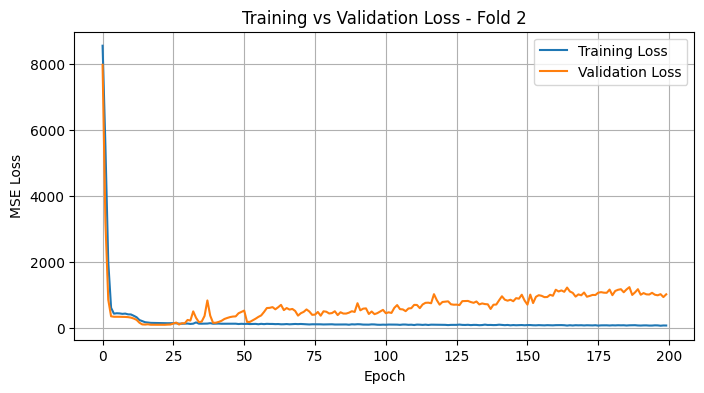

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7961.8745 - val_loss: 7781.8784
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4011.1365 - val_loss: 2824.4604
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1197.8313 - val_loss: 881.0766
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 471.5948 - val_loss: 510.0100
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 405.3828 - val_loss: 487.3922
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 395.7043 - val_loss: 490.8986
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 410.0947 - val_loss: 479.6906
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 397.5781 - val_loss: 476.9404
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 383.5523 - val_loss: 482.1469
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 392.8170 - val_loss: 476.5680
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 361.8938 - val_loss: 434.1987
Epoch 12/200
4

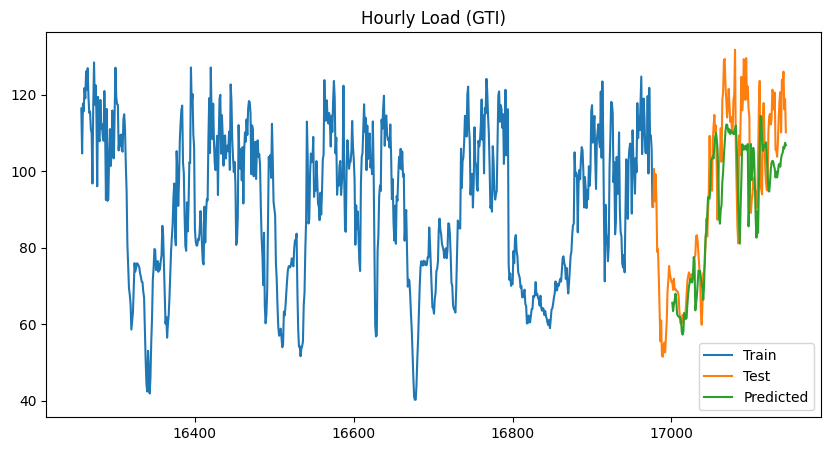

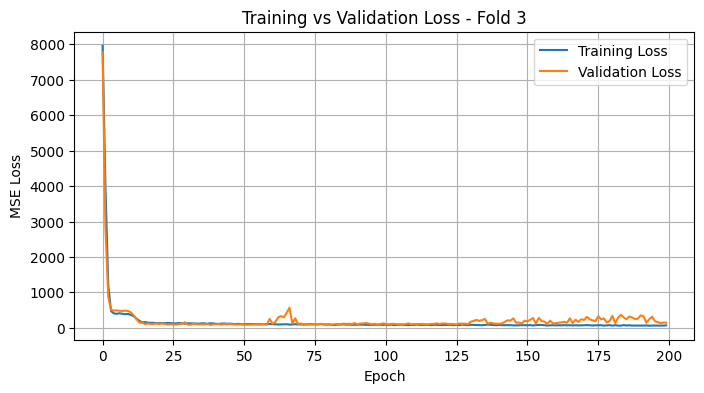

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8144.0151 - val_loss: 7927.1606
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4384.4692 - val_loss: 3329.4470
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1493.7450 - val_loss: 1084.7339
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 544.4175 - val_loss: 514.1829
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 435.4573 - val_loss: 463.2465
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 430.6326 - val_loss: 448.7176
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 432.8743 - val_loss: 451.7628
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 416.5884 - val_loss: 449.6385
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 429.8913 - val_loss: 443.7303
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 411.8459 - val_loss: 449.6220
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 399.4175 - val_loss: 430.8874
Epoch 12/200


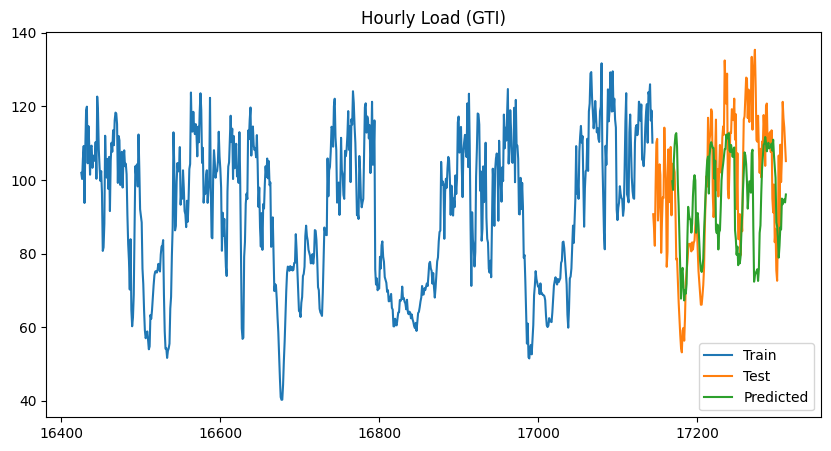

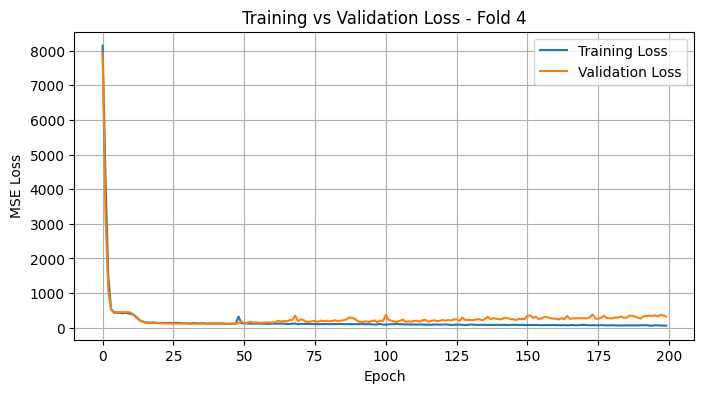

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8460.2080 - val_loss: 6207.6860
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5211.7329 - val_loss: 2899.1394
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2207.6567 - val_loss: 904.2681
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 764.1368 - val_loss: 368.6615
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 461.9496 - val_loss: 357.6598
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 421.5982 - val_loss: 364.6646
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 423.6471 - val_loss: 366.0313
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 435.1152 - val_loss: 363.7457
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 442.7703 - val_loss: 367.8722
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 442.8165 - val_loss: 362.0531
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 440.7390 - val_loss: 363.3627
Epoch 12/200
4

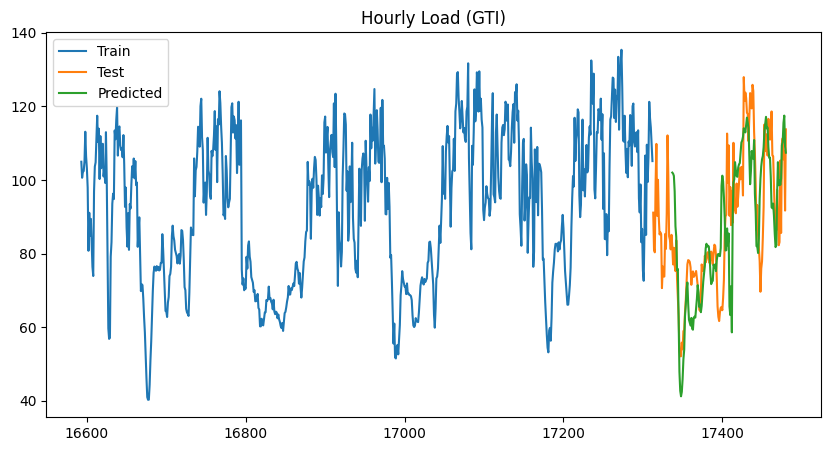

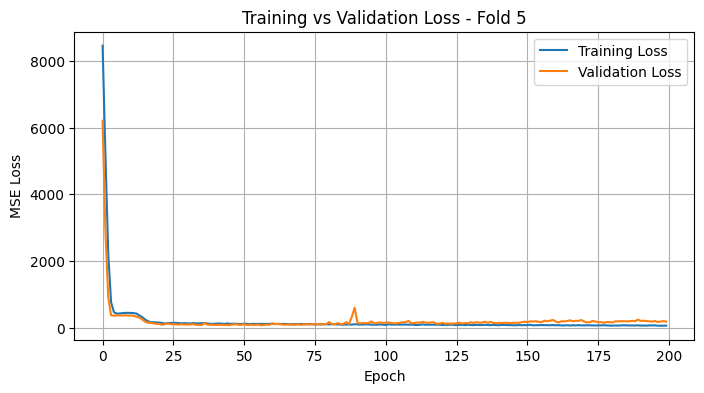

GSI
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2023.2382 - val_loss: 1597.5531
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 580.1235 - val_loss: 259.0487
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 170.5073 - val_loss: 220.7138
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 170.3960 - val_loss: 219.2471
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 159.7812 - val_loss: 219.1563
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 155.6742 - val_loss: 205.6182
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 152.0856 - val_loss: 181.1459
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 126.4130 - val_loss: 140.1850
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.9507 - val_loss: 104.5306
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77.5477 - val_loss: 82.9236
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 64.5955 - val_loss: 74.0710
Epoch 12/200
44/44

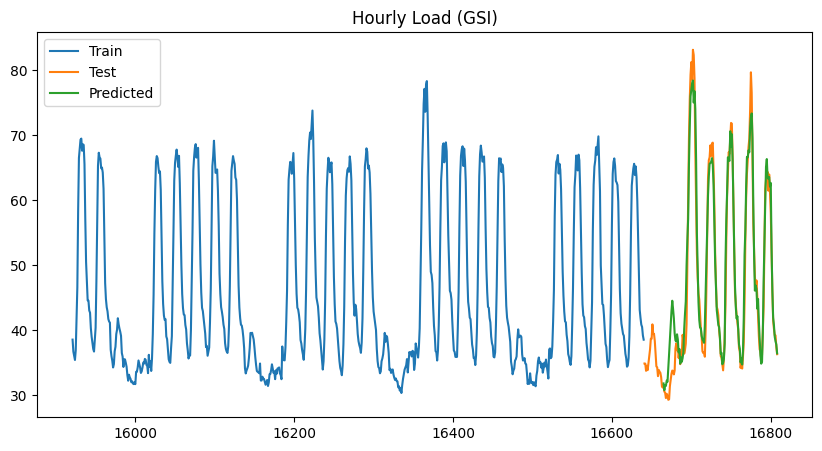

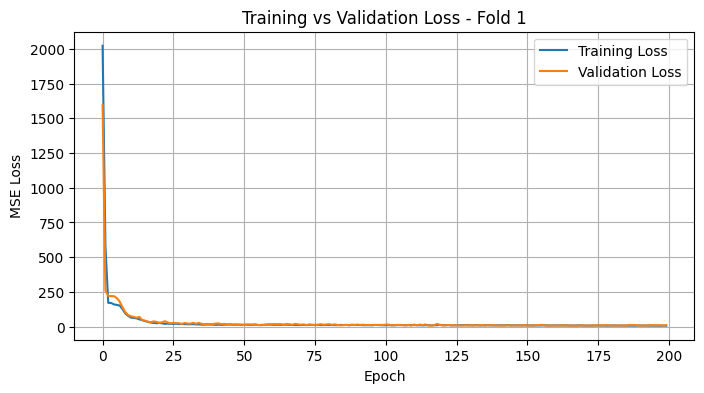

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2098.4580 - val_loss: 1614.5051
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 568.1893 - val_loss: 230.2401
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 185.2427 - val_loss: 207.1788
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 180.4103 - val_loss: 208.7522
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 179.7967 - val_loss: 201.6500
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 170.1736 - val_loss: 182.0470
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 143.2637 - val_loss: 145.5089
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 114.2522 - val_loss: 102.6381
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92.6979 - val_loss: 82.7071
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76.0595 - val_loss: 63.9951
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.0716 - val_loss: 57.8381
Epoch 12/200
44/44 ━━━━

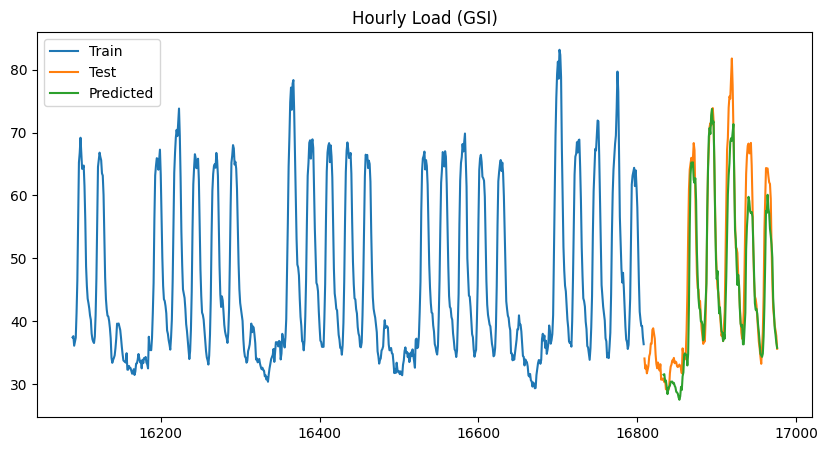

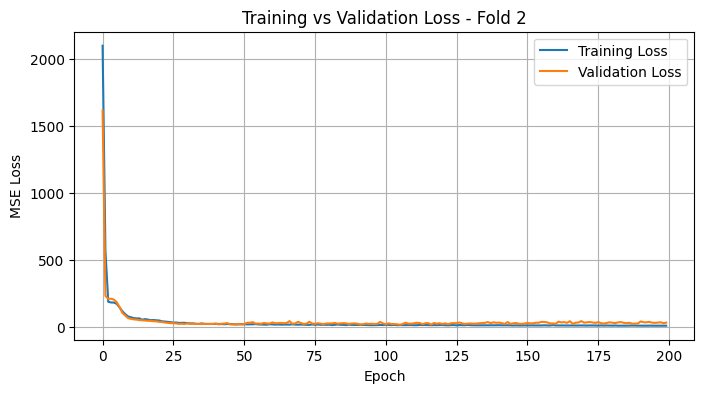

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2217.3047 - val_loss: 1742.2222
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1001.0019 - val_loss: 461.4646
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 281.9886 - val_loss: 180.8722
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 193.0299 - val_loss: 168.8497
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 189.3282 - val_loss: 169.3055
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196.5722 - val_loss: 168.2170
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 184.1408 - val_loss: 164.3524
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 183.1520 - val_loss: 151.4827
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 162.2399 - val_loss: 123.1192
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 125.2671 - val_loss: 93.1159
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.4311 - val_loss: 73.6066
Epoch 12/200
44/44

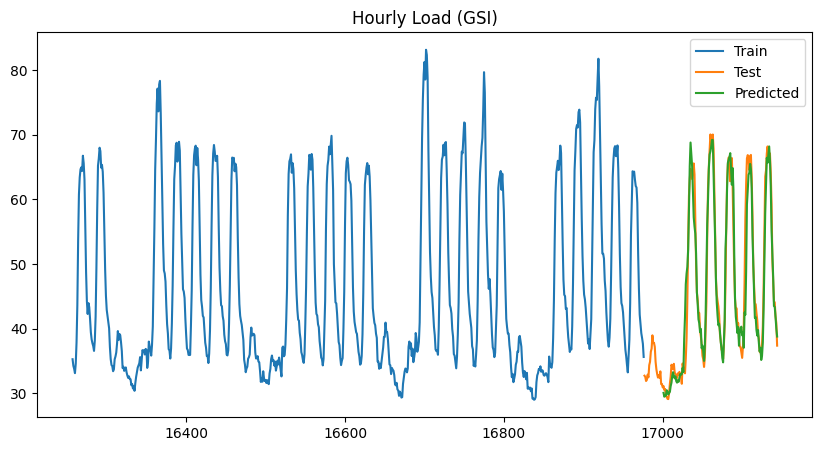

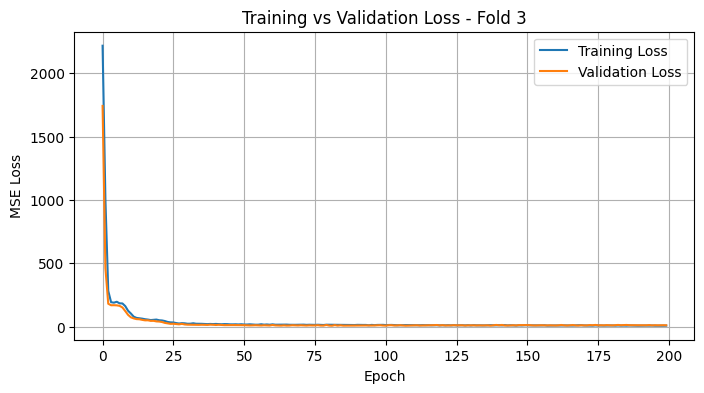

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2160.5020 - val_loss: 2505.8818
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 970.0020 - val_loss: 703.7549
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 246.1819 - val_loss: 311.4526
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 187.6680 - val_loss: 301.4916
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 186.4453 - val_loss: 293.2275
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 177.3596 - val_loss: 283.0315
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 167.5767 - val_loss: 247.9432
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141.6665 - val_loss: 196.3529
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108.5895 - val_loss: 154.7329
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.9047 - val_loss: 124.0017
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85.6118 - val_loss: 101.8851
Epoch 12/200
44/44 

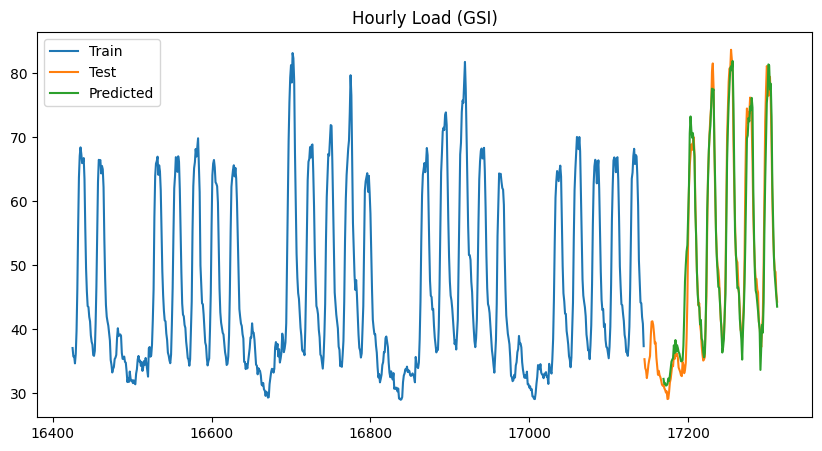

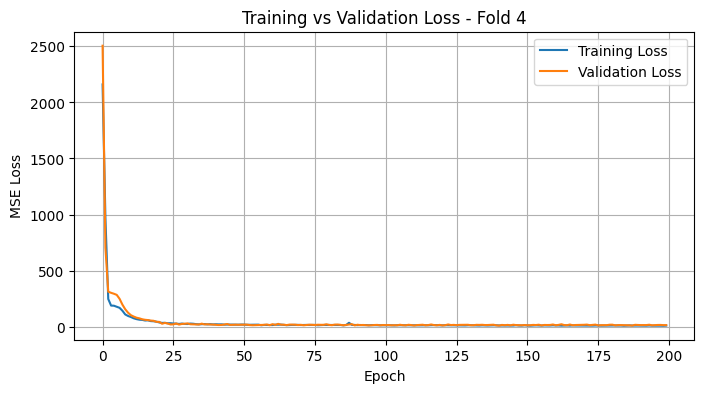

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2217.7742 - val_loss: 1813.2336
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 750.5051 - val_loss: 309.8079
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 224.9250 - val_loss: 201.9433
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 222.5821 - val_loss: 203.2611
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 216.5638 - val_loss: 198.7861
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 200.5854 - val_loss: 176.6451
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163.9005 - val_loss: 134.8936
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119.3492 - val_loss: 101.5748
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 96.4236 - val_loss: 81.7491
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 88.5029 - val_loss: 73.3101
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78.9090 - val_loss: 65.1475
Epoch 12/200
44/44 ━━━━

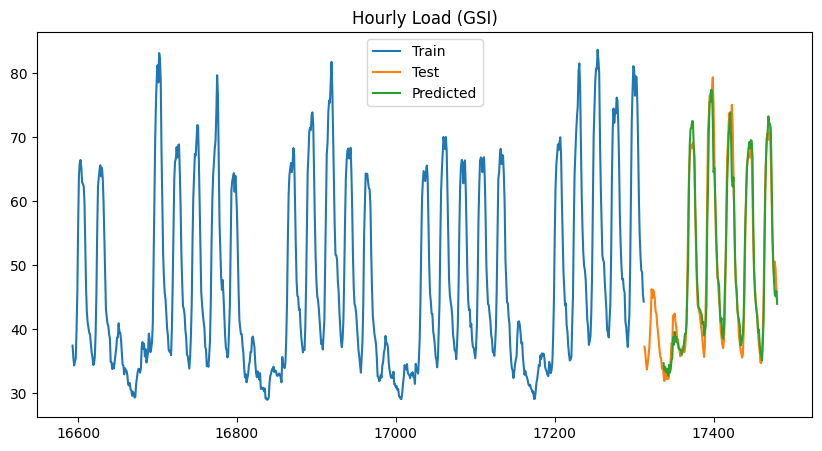

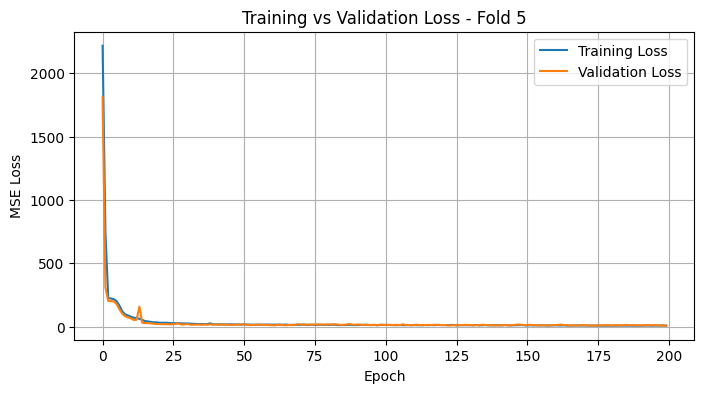

CIEP
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 245925.8125 - val_loss: 219961.2969
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 224330.7344 - val_loss: 191537.9375
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 193071.7656 - val_loss: 159488.8594
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 157618.2188 - val_loss: 124066.8906
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 120124.6797 - val_loss: 89319.0156
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84833.3359 - val_loss: 58902.7422
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55804.6484 - val_loss: 35125.8828
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34142.0039 - val_loss: 19073.4824
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19592.9590 - val_loss: 9725.8916
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11156.1777 - val_loss: 5317.0254
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

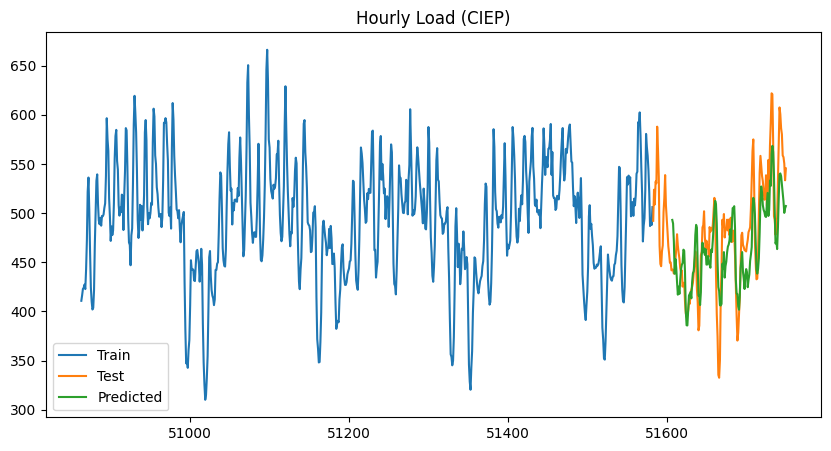

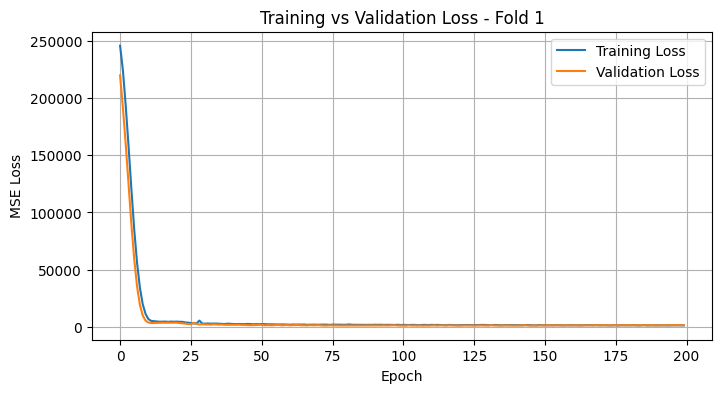

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 242140.2969 - val_loss: 267343.6250
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 232058.6875 - val_loss: 252834.6719
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 217254.9844 - val_loss: 231623.4375
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 197747.6719 - val_loss: 203291.1875
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 173581.9844 - val_loss: 171081.1250
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 148522.3750 - val_loss: 138288.9375
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 122323.6016 - val_loss: 105842.7109
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 98495.5781 - val_loss: 76994.2266
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79516.0625 - val_loss: 55153.9805
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62781.7578 - val_loss: 38771.6953
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

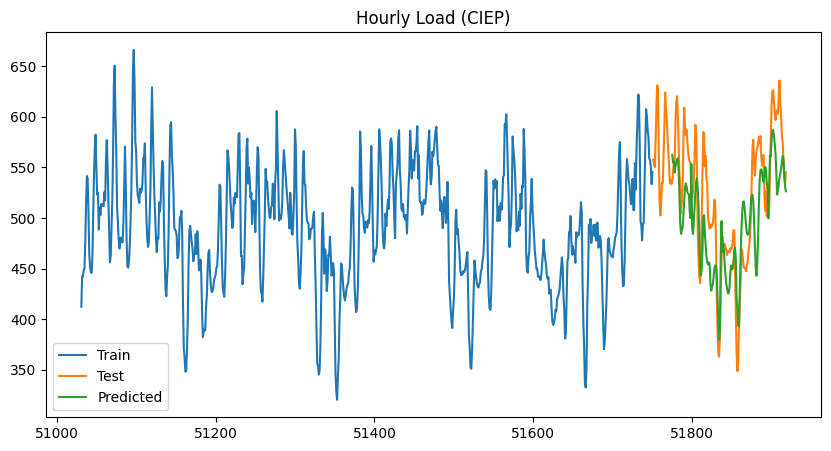

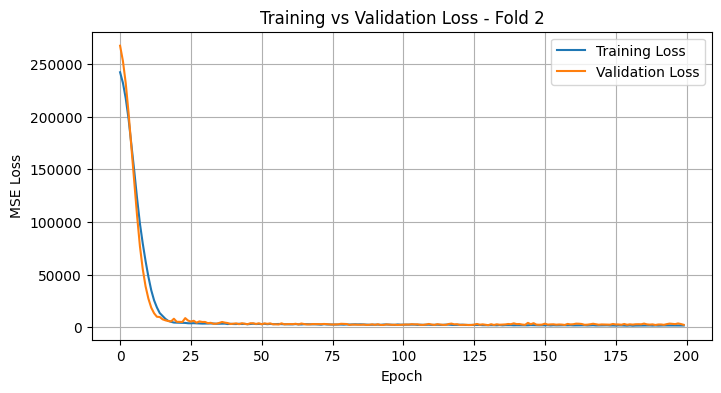

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 250133.4062 - val_loss: 266705.7188
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 238310.4531 - val_loss: 249070.3125
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 212978.8750 - val_loss: 210292.6406
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 173836.6406 - val_loss: 167440.5938
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 132460.6719 - val_loss: 123974.0547
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92957.5781 - val_loss: 84081.7969
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 59512.1680 - val_loss: 52482.1953
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35243.9180 - val_loss: 30496.1172
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19471.6504 - val_loss: 16615.9629
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10640.6592 - val_loss: 8918.0605
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

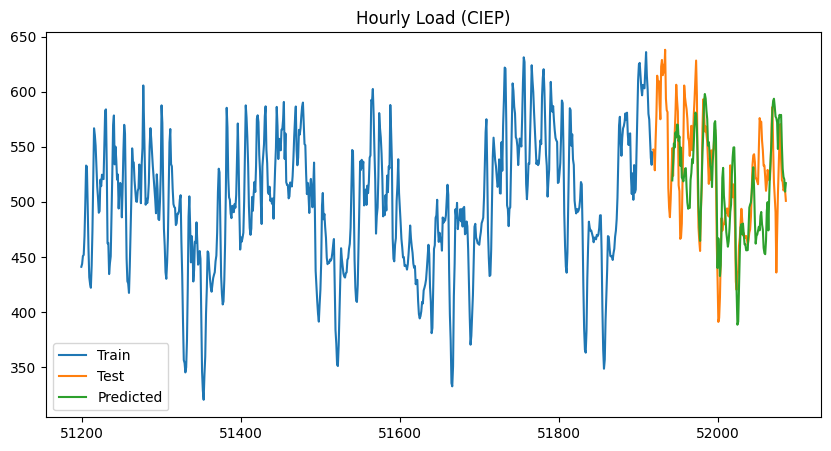

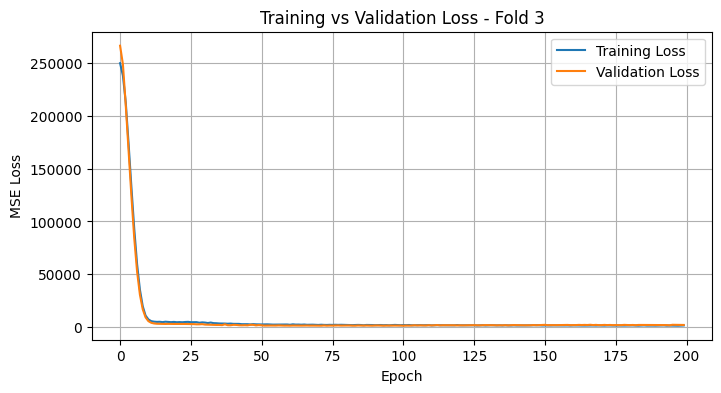

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 259708.4531 - val_loss: 253465.1875
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 235489.2188 - val_loss: 217537.9219
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 195712.0000 - val_loss: 178475.6250
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 154060.4531 - val_loss: 138509.5625
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 112677.2031 - val_loss: 100884.3047
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76327.6875 - val_loss: 69164.7109
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46638.8125 - val_loss: 45449.4883
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26740.3789 - val_loss: 29936.8984
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15057.7070 - val_loss: 21141.4785
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8595.7734 - val_loss: 16754.7109
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

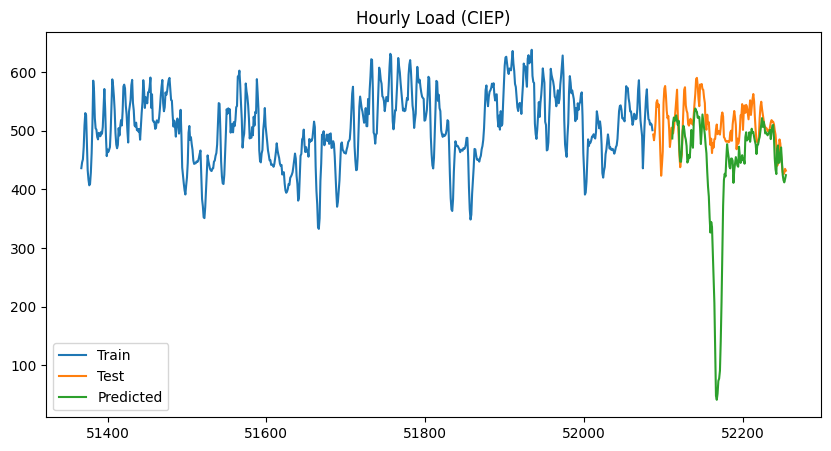

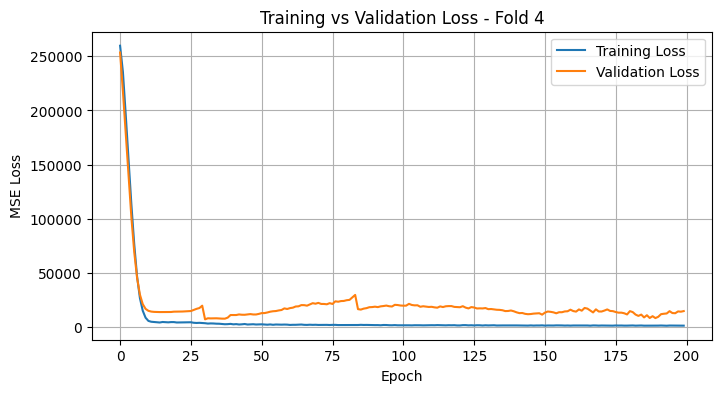

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 261588.5938 - val_loss: 225677.4375
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 240417.6719 - val_loss: 195911.2344
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 208025.3750 - val_loss: 162987.5312
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 171039.1250 - val_loss: 127242.9453
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 131725.3594 - val_loss: 91382.7031
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94528.2031 - val_loss: 59126.2070
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 61666.9414 - val_loss: 34254.1484
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37258.1719 - val_loss: 17305.0371
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21109.1641 - val_loss: 7667.5435
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12075.6377 - val_loss: 3181.7175
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70

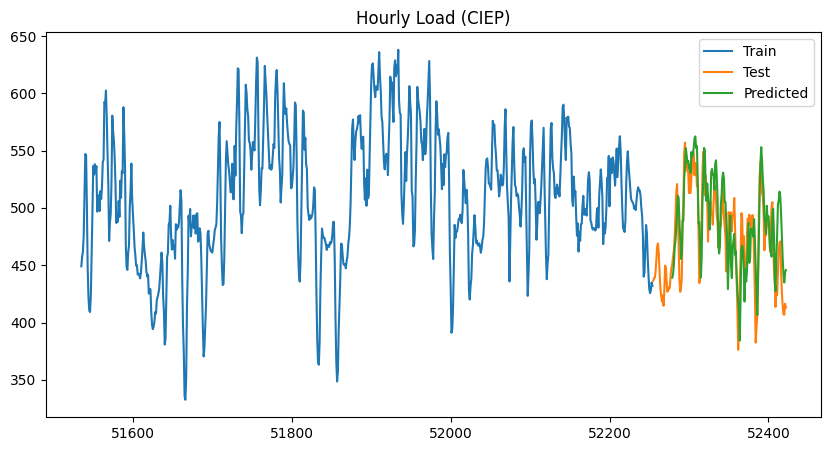

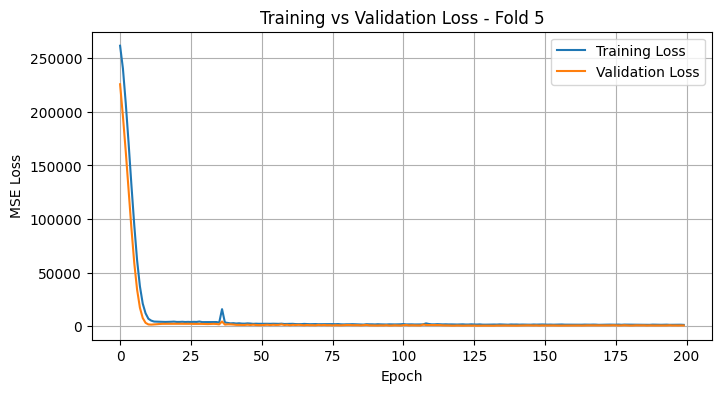

GPC
Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3517.3169 - val_loss: 3228.0244
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1448.8256 - val_loss: 924.2421
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 218.4427 - val_loss: 158.0864
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76.6002 - val_loss: 128.4705
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.9212 - val_loss: 136.6614
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.0294 - val_loss: 135.9133
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 73.2511 - val_loss: 126.8903
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.9109 - val_loss: 139.7834
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.7860 - val_loss: 136.0965
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 72.7252 - val_loss: 131.1078
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 69.9234 - val_loss: 125.9762
Epoch 12/200
44/44 ━

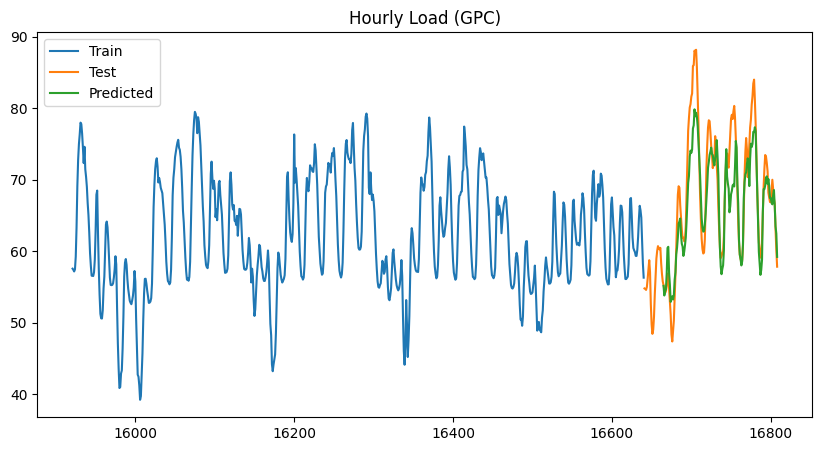

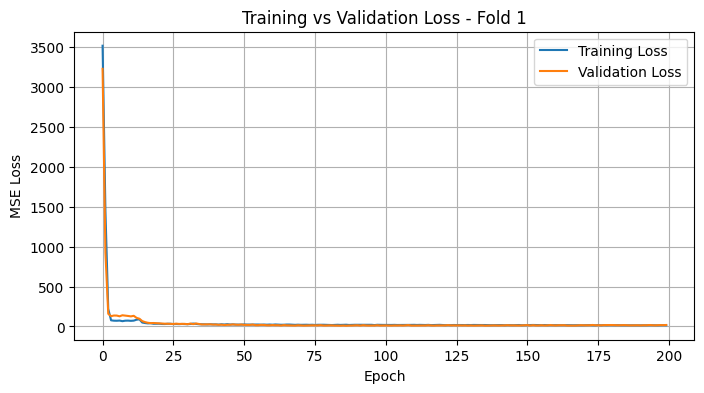

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3784.6106 - val_loss: 4111.1455
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1838.3812 - val_loss: 1298.6184
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 383.0429 - val_loss: 232.9071
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79.6042 - val_loss: 132.9625
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82.7263 - val_loss: 138.9010
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79.7824 - val_loss: 144.6632
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78.6238 - val_loss: 143.5945
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 81.0612 - val_loss: 146.8703
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 81.0535 - val_loss: 143.2470
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76.8127 - val_loss: 136.3622
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82.3718 - val_loss: 130.9783
Epoch 12/200
44/44 ━━━━

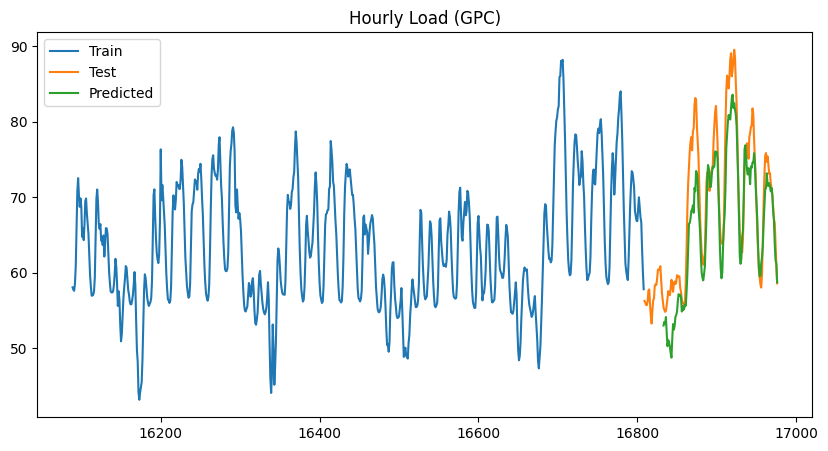

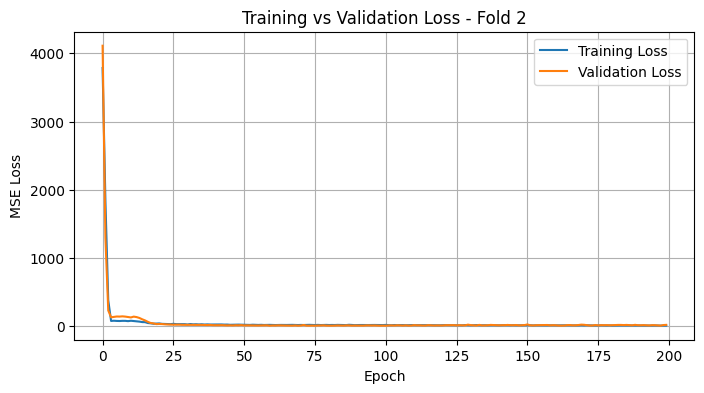

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3866.1157 - val_loss: 3367.0654
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1331.8636 - val_loss: 475.3114
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 146.4624 - val_loss: 110.1720
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 96.5862 - val_loss: 113.9157
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93.2091 - val_loss: 111.1834
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 99.7259 - val_loss: 113.8456
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 93.3850 - val_loss: 109.8633
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 89.6362 - val_loss: 100.1189
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 89.8960 - val_loss: 97.7120
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 78.1017 - val_loss: 87.9744
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 71.7785 - val_loss: 67.6352
Epoch 12/200
44/44 ━━━━━━━━

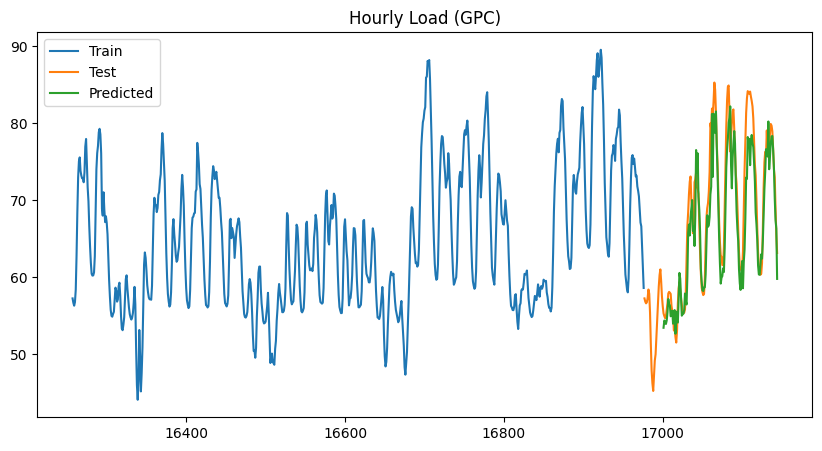

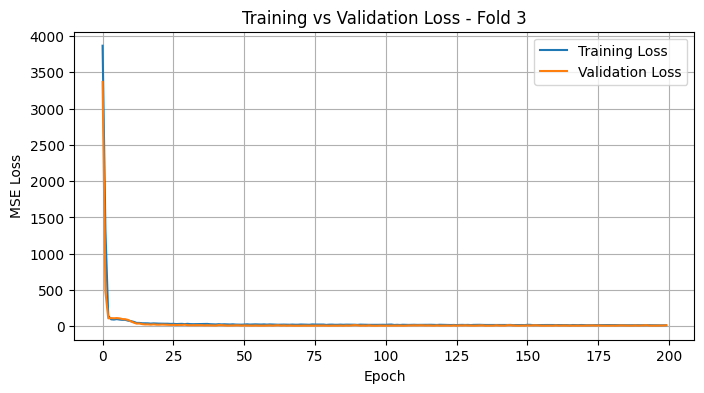

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4035.9229 - val_loss: 4977.7739
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2716.0886 - val_loss: 3381.8481
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1376.5474 - val_loss: 1924.2980
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 537.3749 - val_loss: 886.2761
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 210.9737 - val_loss: 408.2233
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 106.7247 - val_loss: 212.1003
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 83.7016 - val_loss: 167.6393
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 86.6519 - val_loss: 164.2383
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77.2692 - val_loss: 162.5081
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79.8373 - val_loss: 141.8340
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 81.6631 - val_loss: 135.9291
Epoch 12/200
44/44

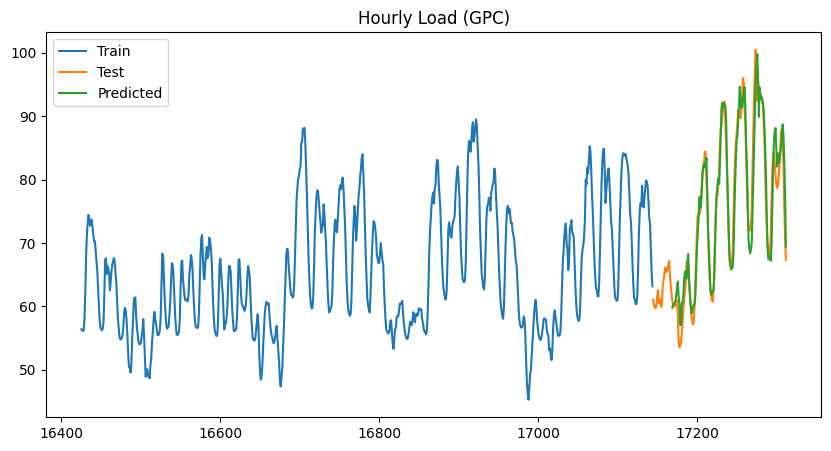

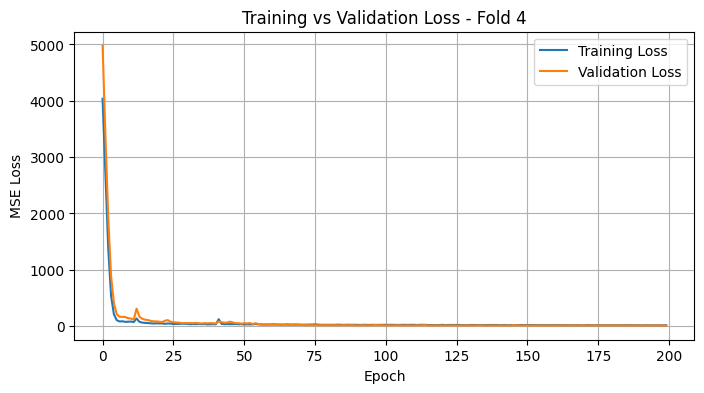

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4563.6206 - val_loss: 4430.6816
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2667.9902 - val_loss: 1936.4166
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 801.8458 - val_loss: 390.9489
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 174.1260 - val_loss: 99.7114
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 136.1616 - val_loss: 100.7551
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 134.9953 - val_loss: 99.2339
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 142.2866 - val_loss: 97.2876
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141.2309 - val_loss: 101.2777
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 129.0284 - val_loss: 88.1525
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.0427 - val_loss: 64.0333
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86.3377 - val_loss: 53.1327
Epoch 12/200
44/44 ━━━

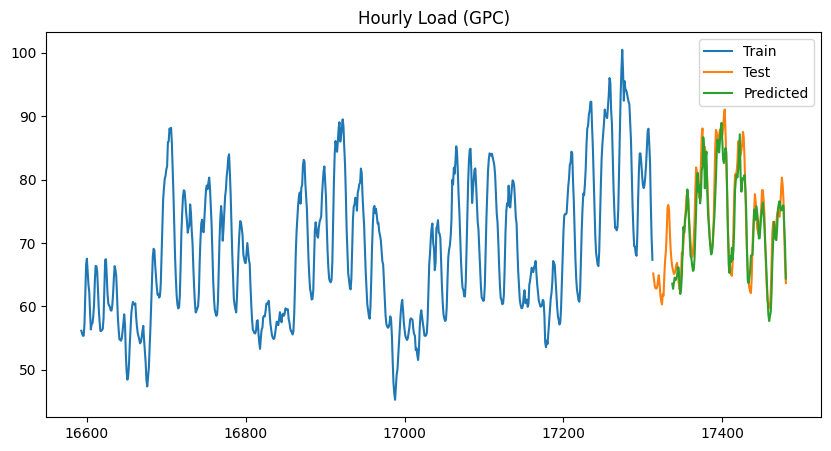

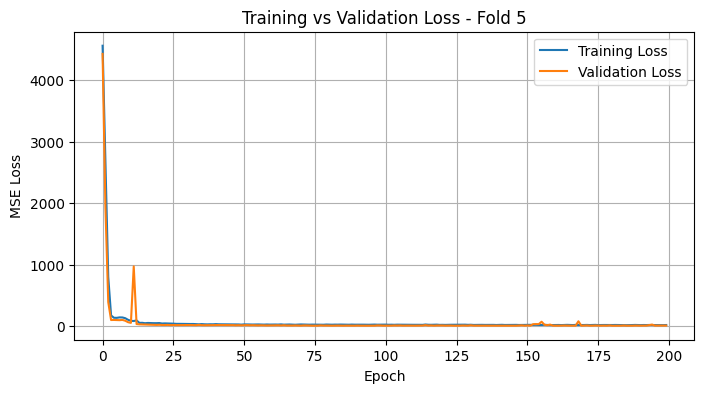

In [29]:

for name, rc in rateclasses.items():
    print(name)
    data = get_data(rc)
    X = data.select(
        "Temperature",
        "Temperature^2",
        "snowy",
        "cloudy",
        "windy",
        "sunny",
        "stormy",
        "lag-1h",
        "lag-24h",
    ).to_numpy()
    y = data.select("Load").to_numpy().ravel()

    TRAIN_DAYS = 30
    TEST_DAYS = 7
    WINDOW = 24

    tss = TimeSeriesSplit(n_splits=5, max_train_size=TRAIN_DAYS * 24, test_size=TEST_DAYS * 24)
    for i, (train_index, test_index) in enumerate(tss.split(X)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train, WINDOW)
        X_test_seq,  y_test_seq  = make_sequences(X_test_scaled, y_test, WINDOW)

        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(WINDOW, X.shape[1])),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

        model.compile(optimizer="adam", loss="mse")

        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_test_seq, y_test_seq),
            epochs=200,
            batch_size=16
        )

        y_pred = model.predict(X_test_seq)

        y_true = y_test[WINDOW:]
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
        print(mae, mape, np.sqrt(mse))

        fig = plt.figure(figsize=(10, 5))
        plt.title(f"Hourly Load ({name})")
        plt.plot(train_index, y_train)
        plt.plot(test_index, y_test)
        plt.plot(test_index[WINDOW:], y_pred, label="Predicted")
        plt.legend(["Train", "Test", "Predicted"])
        plt.show()

        plt.figure(figsize=(8, 4))
        plt.title("Training vs Validation Loss - Fold {}".format(i+1))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.show()